In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from collections import defaultdict
from scipy import integrate
from scipy.stats import chi2
from iminuit import minimize, Minuit
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
bins_min, bins_max, bins_w = 120, 230, 1
bins = np.arange(bins_min, bins_max+1, bins_w)
bins_mid = bins[:-1]+bins_w/2
bins_dense = np.linspace(bins_min, bins_max, 1000)

mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)
top_mass_chi2 = np.linspace(166, 180, 1000)
sudo_bins = np.arange(166, 180, 0.2)
sudo_bins_dense = np.linspace(166, 180, 1000)

loglikeli_cut_min = -78
loglikeli_cut_max = -54
marginal_prob_cut = 0.23

sudo_event = 10000

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
state_labels = ['Unmatched', 'Incorrect', 'Correct']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Std of Gaussian', 'Fraction of Gaussian']


In [3]:
def get_reco_top_mass(h5py_file, target): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)
    # py = pt*sin(phi)
    # pz = pt*sinh(eta)
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)*JSF
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    bins_min < reco_m_top < bins_max
    additional cuts (same as CMS)
    """
    reco_cuts = np.logical_and(dic['reconstructed_top_mass'] > bins_min, dic['reconstructed_top_mass'] < bins_max)

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], state, reco_cuts, np.logical_and(h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut_min, h5py_file['klfitter/score/loglikelihood'][:]<loglikeli_cut_max)
    elif target == 'spanet': return dic['reconstructed_top_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], state, reco_cuts
    

In [4]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}
reco_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}
reco_true_dic, state_true_dic, cut_true_dic = {}, {}, {}

for m in mass:
    h5py_file = h5py.File('ttbar_testing_mass_variation/ttbar_testing_{}_gev_with_spanet_pdnn_KLFitter.h5'.format(m), "r")
    reco_klf_dic[m], state_klf_dic[m], cut_klf_dic[m], likeli_klf_dic[m] = get_reco_top_mass(h5py_file, 'klfitter')
    reco_spanet_dic[m], state_spanet_dic[m], cut_spanet_dic[m], likeli_spanet_dic[m] = get_reco_top_mass(h5py_file, 'spanet')
    reco_true_dic[m], state_true_dic[m], cut_true_dic[m] = get_reco_top_mass(h5py_file, 'target')
    

/tmp/ipykernel_75/1709951665.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2


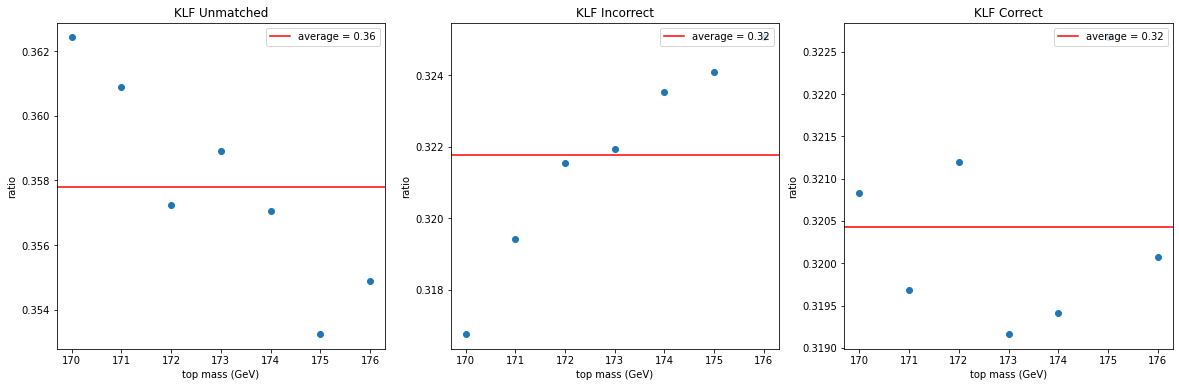

In [5]:
ratio_klf_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]==state_i)/len(state_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])])
        ratio_klf_dic[state_i].append(ratio)
ratio_klf = {key:np.mean(ratio_klf_dic[key]) for key in ratio_klf_dic}

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_klf_dic[state_i])
    plt.axhline(ratio_klf[state_i], c='r', label='average = {:.2f}'.format(ratio_klf[state_i]))
    plt.title('KLF ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
    plt.legend(loc='upper right')
plt.show()


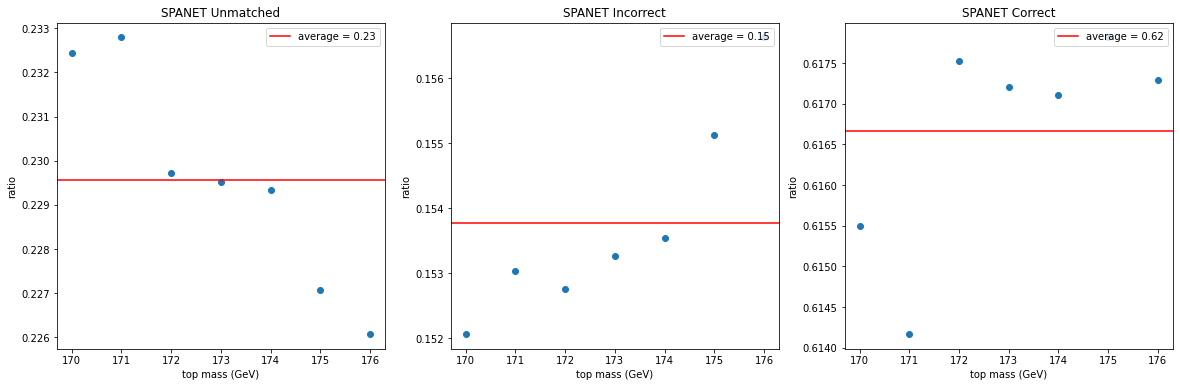

In [6]:
ratio_spanet_dic = defaultdict(list)
for i, m in enumerate(mass):
    for state_i in [0, 1, 2]:
        ratio = np.count_nonzero(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]==state_i)/len(state_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])])
        ratio_spanet_dic[state_i].append(ratio)
ratio_spanet = {key:np.mean(ratio_spanet_dic[key]) for key in ratio_spanet_dic}

plt.figure(figsize=(20, 6))
for state_i in [0, 1, 2]:
    plt.subplot(1, 3, state_i+1)
    plt.scatter(mass, ratio_spanet_dic[state_i])
    plt.axhline(ratio_spanet[state_i], c='r', label='average = {:.2f}'.format(ratio_spanet[state_i]))
    plt.title('SPANET ' + state_labels[state_i])
    plt.xlabel('top mass (GeV)')
    plt.ylabel('ratio')
    plt.legend(loc='upper right')
plt.show()


In [7]:
# Sum of a Landau distribution and a gaussian distribution. Landau currently uses moyal as approximation.
# Nomalized
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between bins_min and bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, x[0]-bins_w/2, x[-1]+bins_w/2, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Gaussian distributions.
def gau_norm(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

# Linear
def linear(x, a, b):
    return a*(x-173)+b

def fcn(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))

def chi2_pdf(observed, pdf): #observed is the observation, pdf is the normalized height of the bins from pdf.
    n1, _ = np.histogram(observed, bins=bins)
    n2 = pdf*bins_w*len(observed)
    return np.sum((n1-n2)**2/n2)

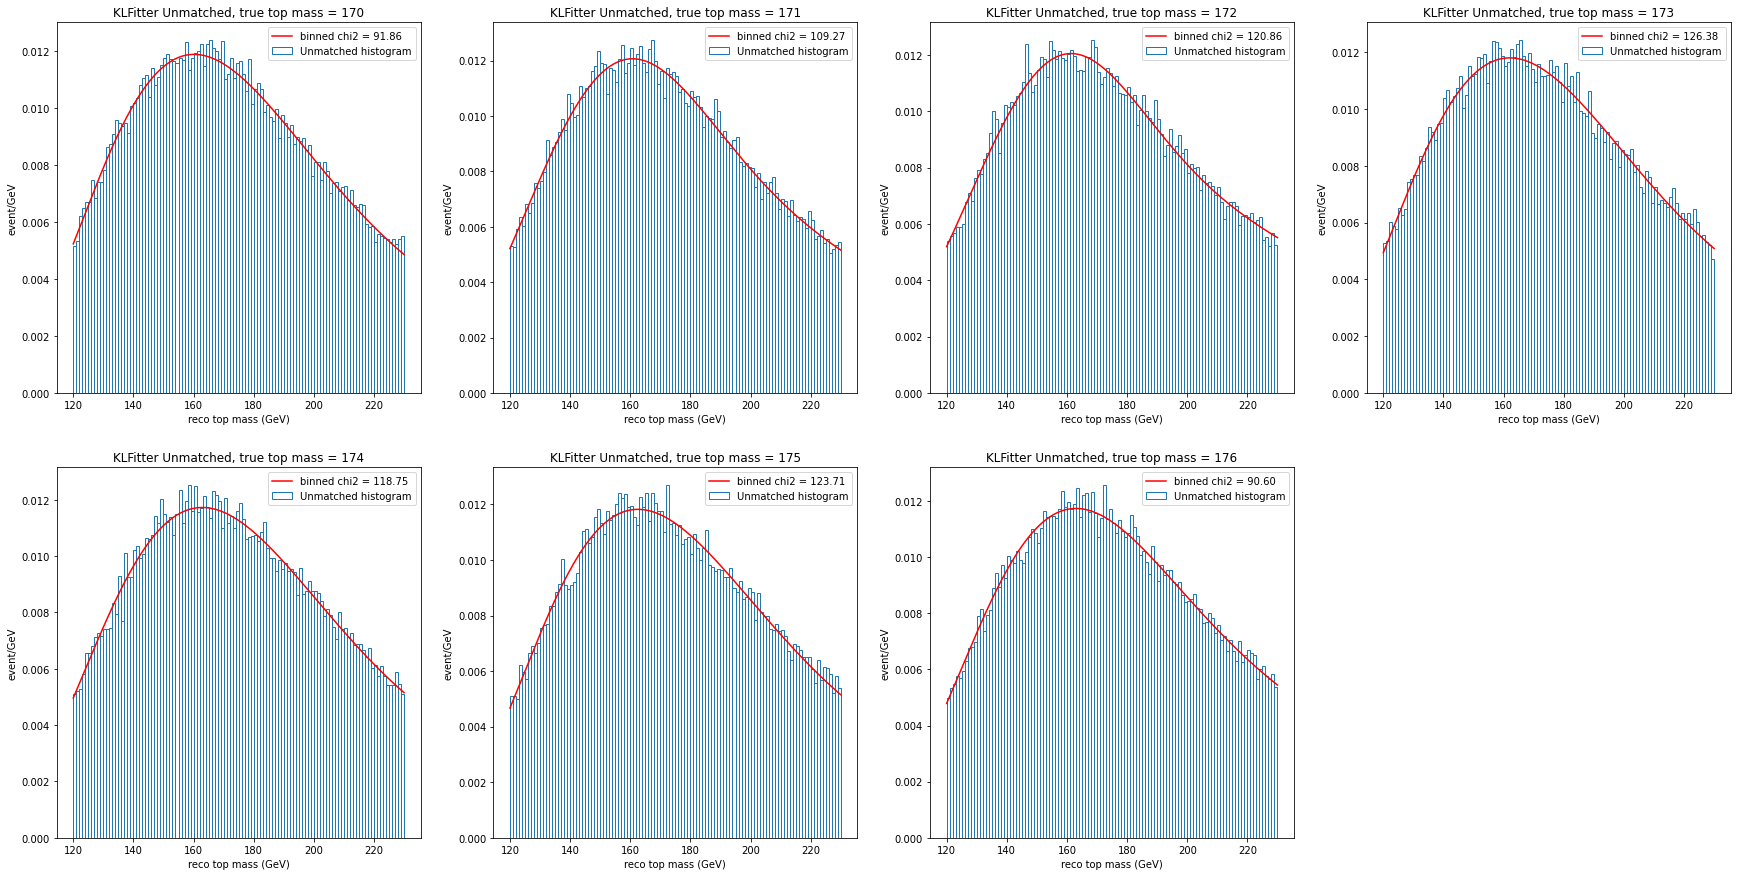

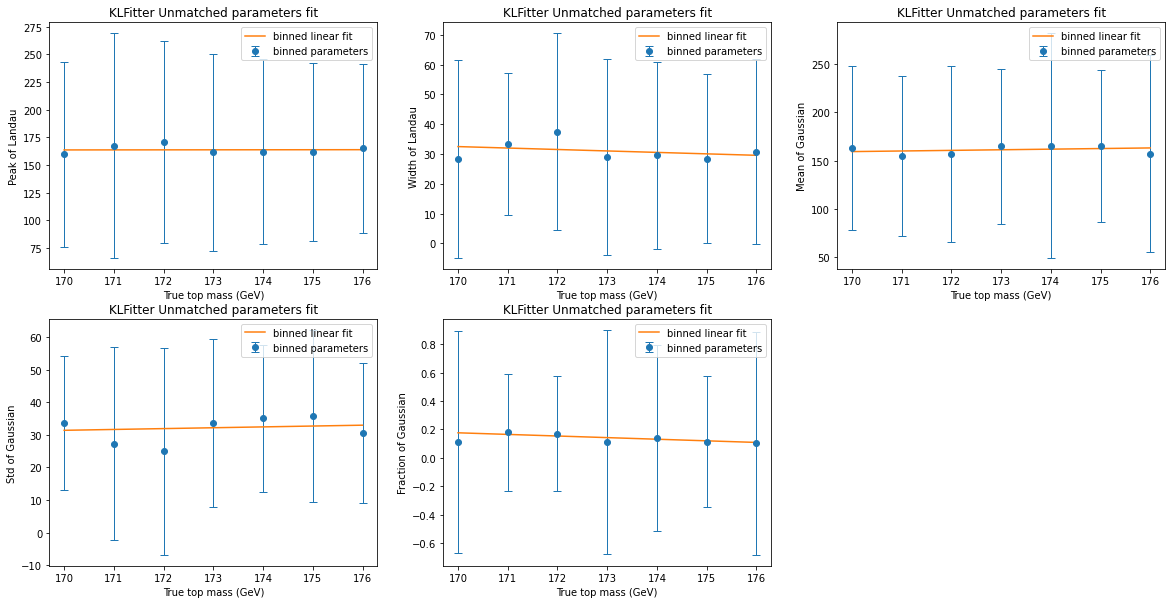

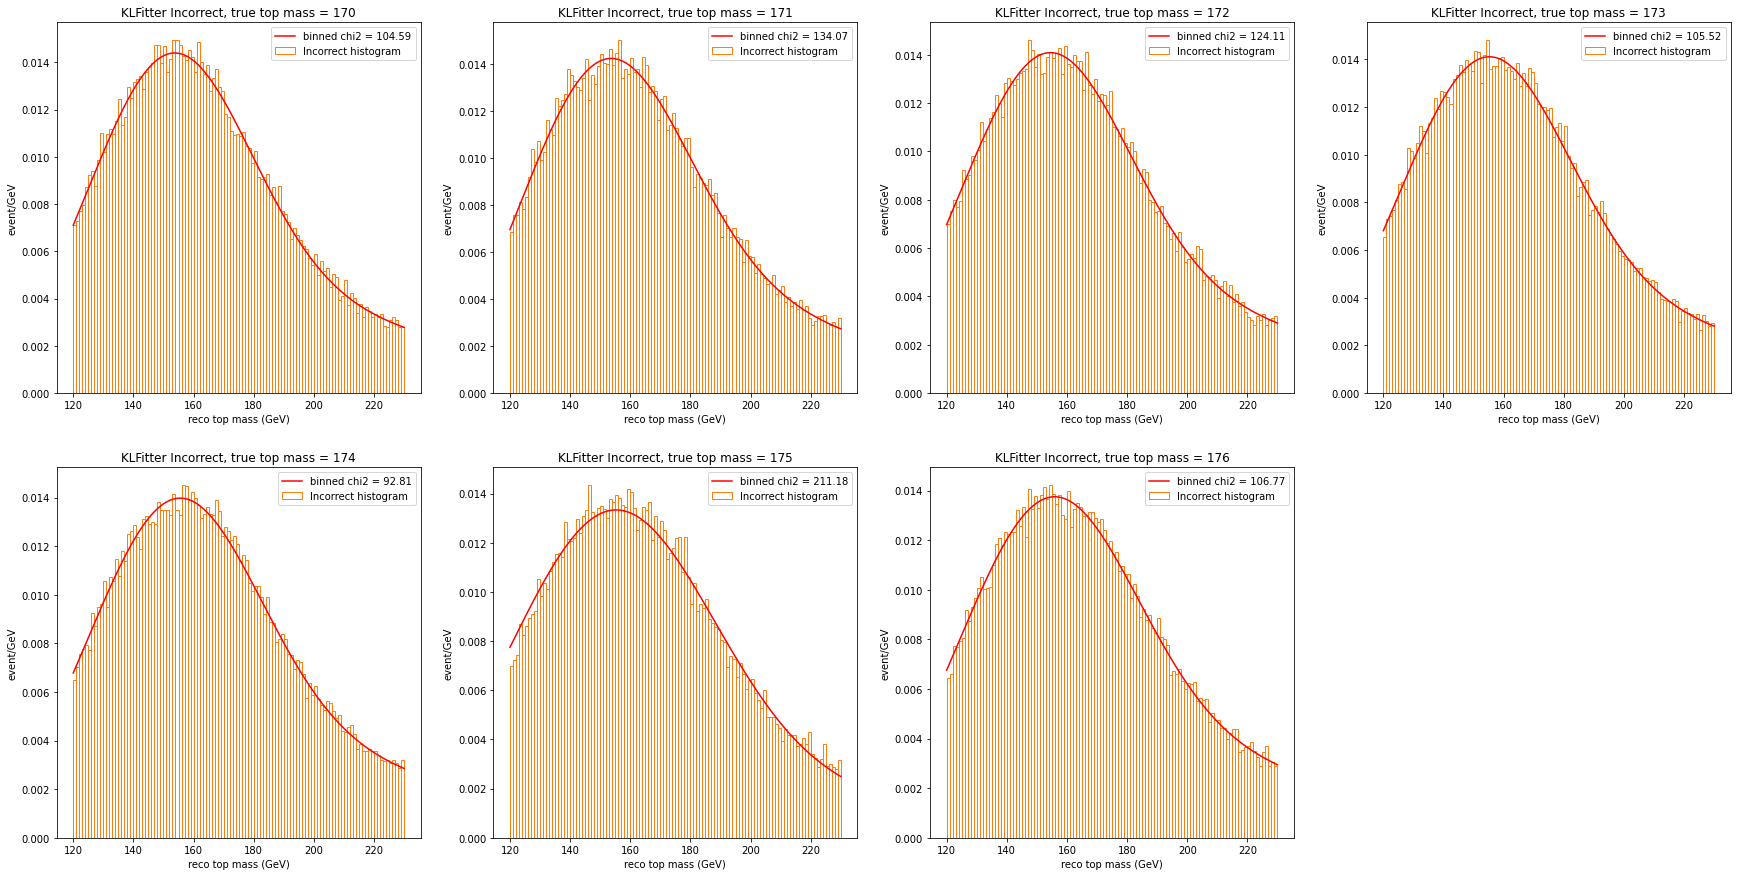

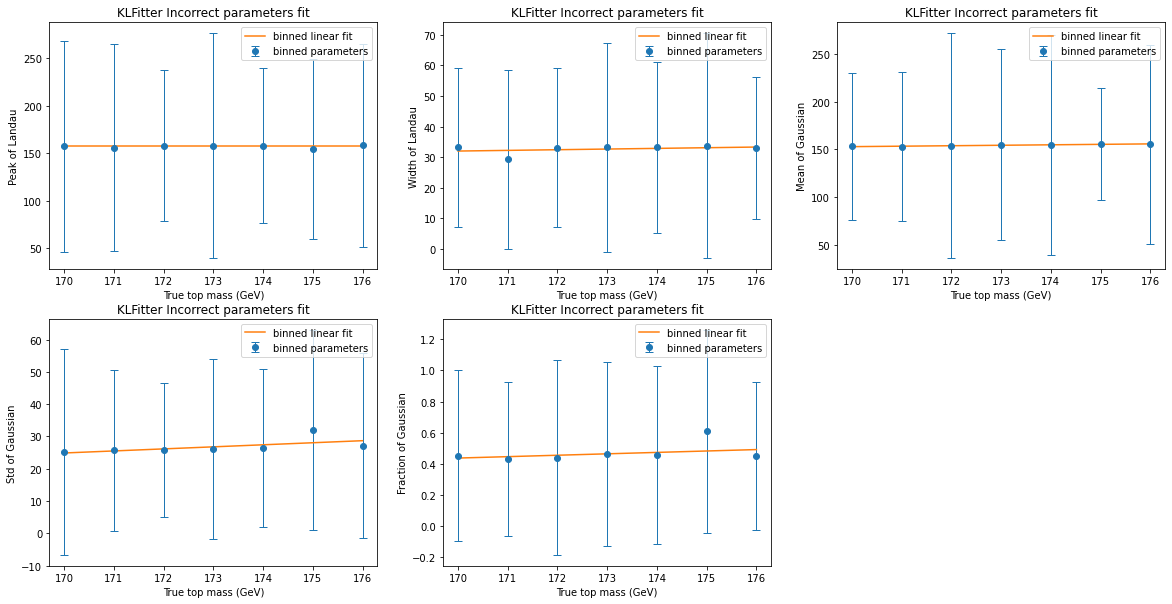

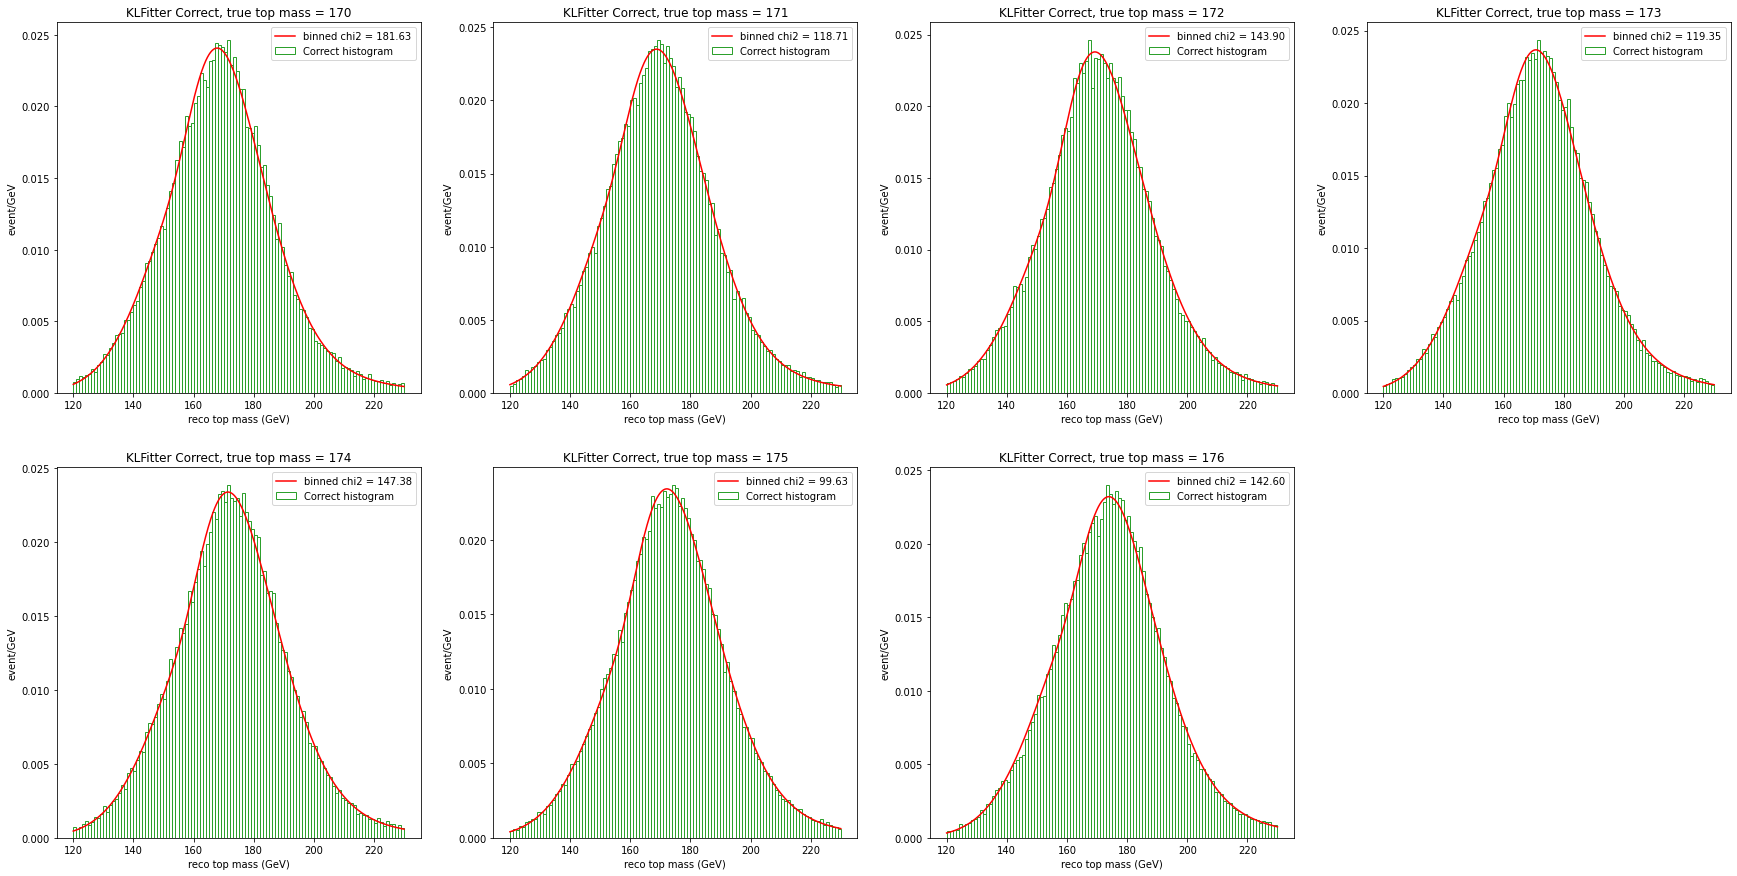

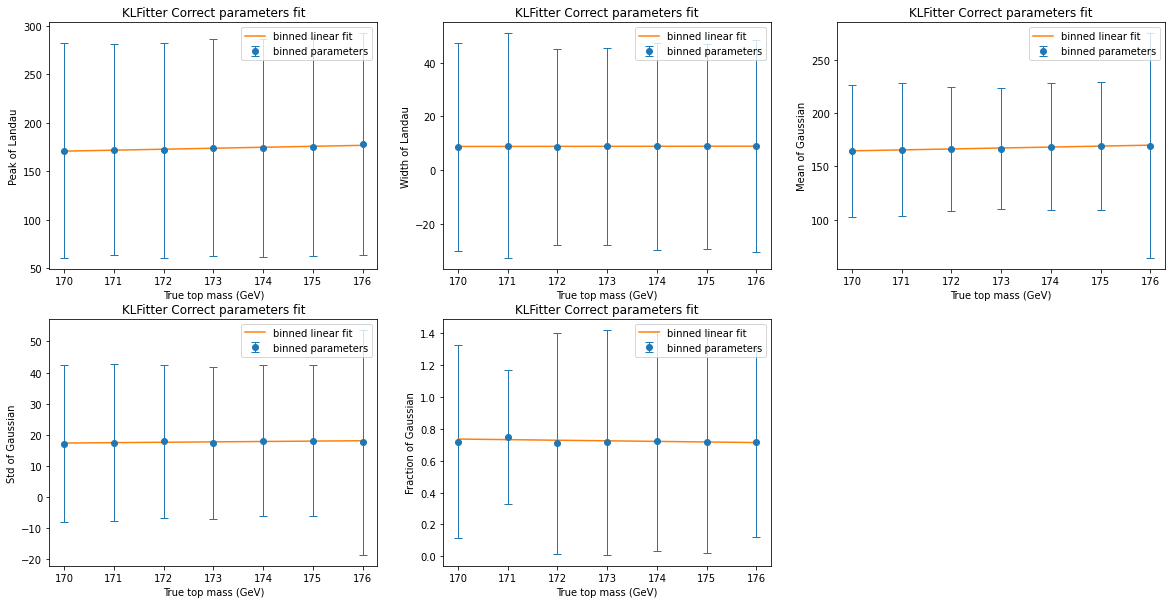

In [8]:
# Fit every class of klfitter
fita_klf_dic, fitb_klf_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_klf_arr = []
    perr_klf_arr = []

    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m]==state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        minuit = Minuit(fcn, 170, 30, 170, 30, 0.5)
        minuit.limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
        minuit.migrad(iterate=1000)
        minuit.minos()
        popt = list(minuit.values)
        errors = list(minuit.errors)
        y_dense = langau_norm(bins_dense, *popt)
        chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        popt_klf_arr.append(popt)
        perr_klf_arr.append(errors)
        plt.title('KLFitter {}, true top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.show()

    popt_klf_arr = np.transpose(np.array(popt_klf_arr))
    fit_popt_dic[state_i] = popt_klf_arr
    perr_klf_arr = np.transpose(np.array(perr_klf_arr))
    fita_klf_arr, fitb_klf_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_klf_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_klf_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_klf_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        fita_klf_arr.append(popt[0])
        fitb_klf_arr.append(popt[1])
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.title('KLFitter {} parameters fit'.format(state_labels[state_i]))
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
        plt.legend(loc='upper right')
    plt.show()
    fita_klf_dic[state_i] = fita_klf_arr
    fitb_klf_dic[state_i] = fitb_klf_arr

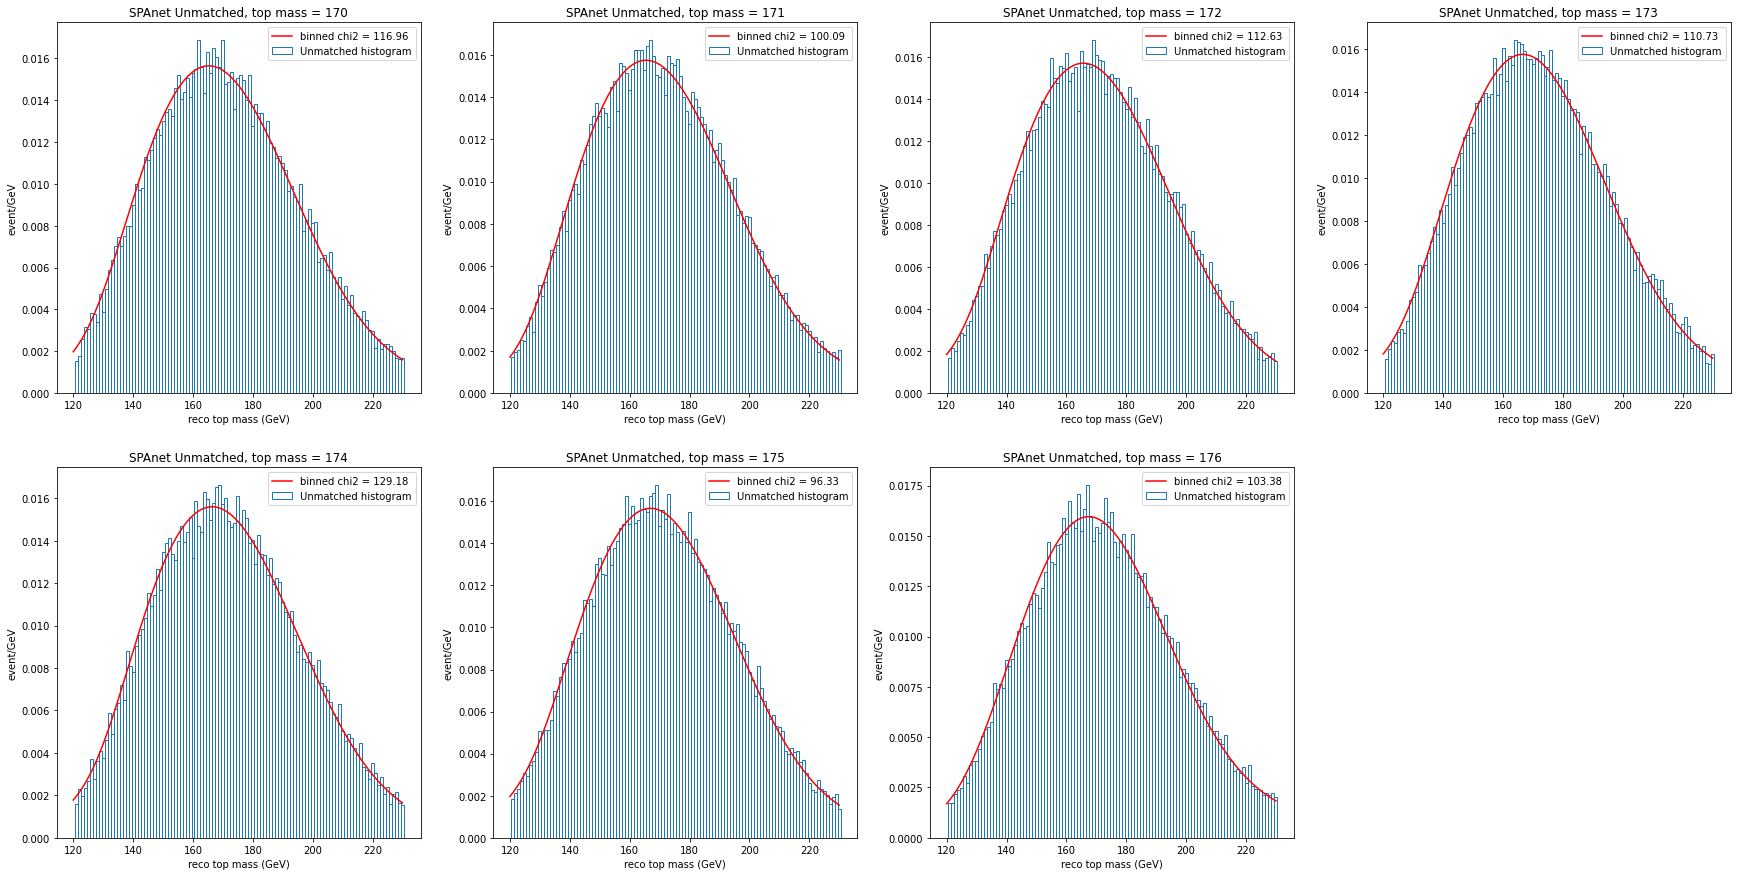

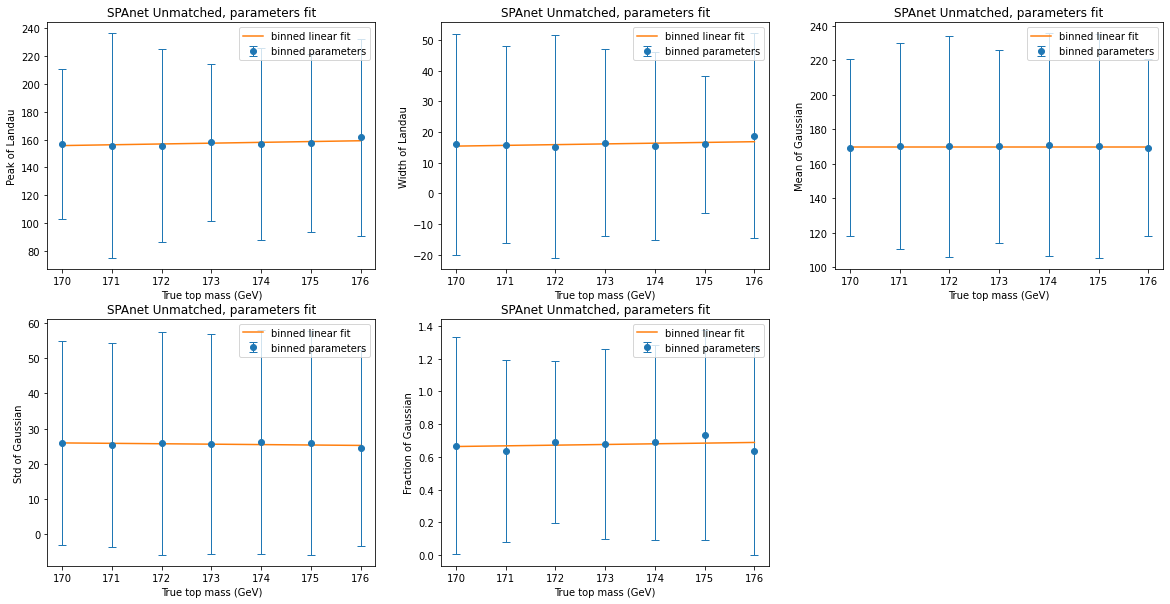

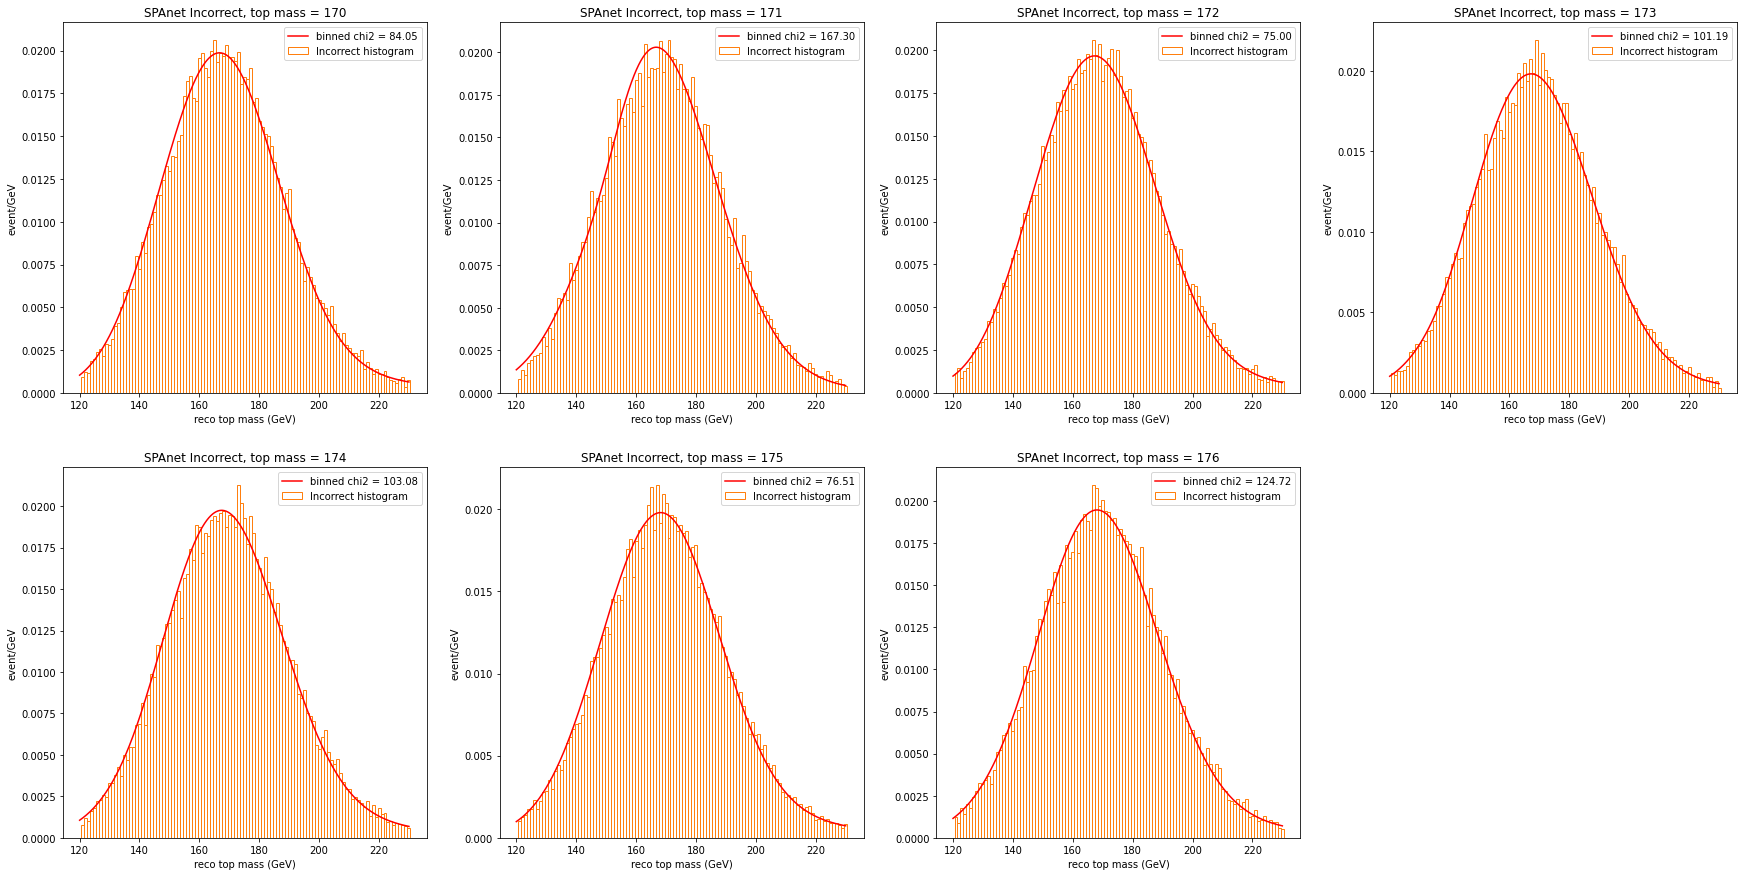

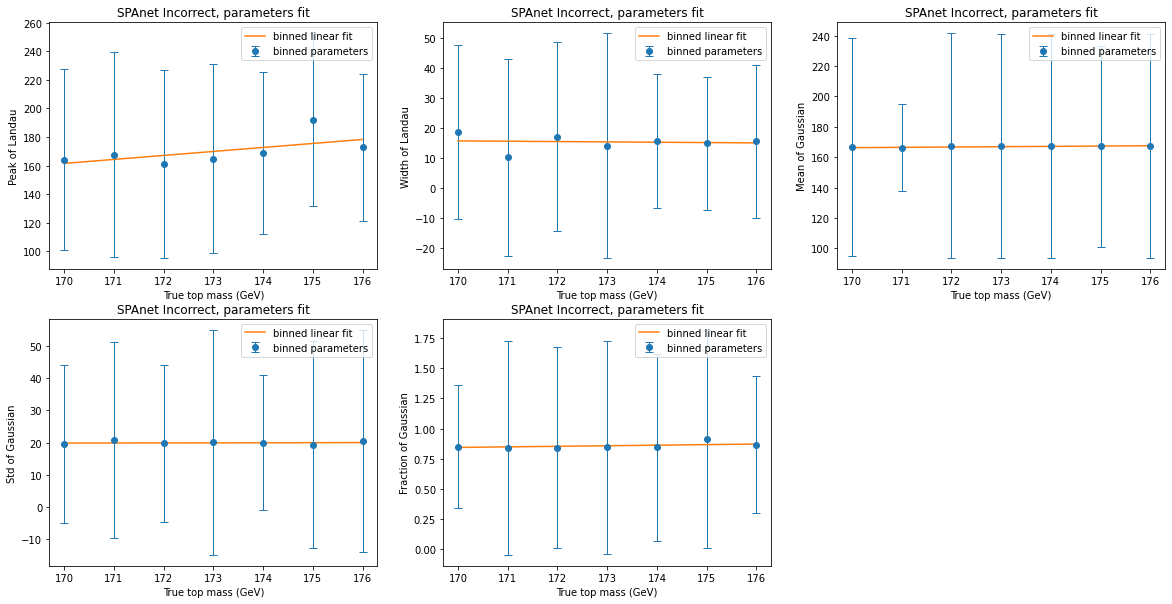

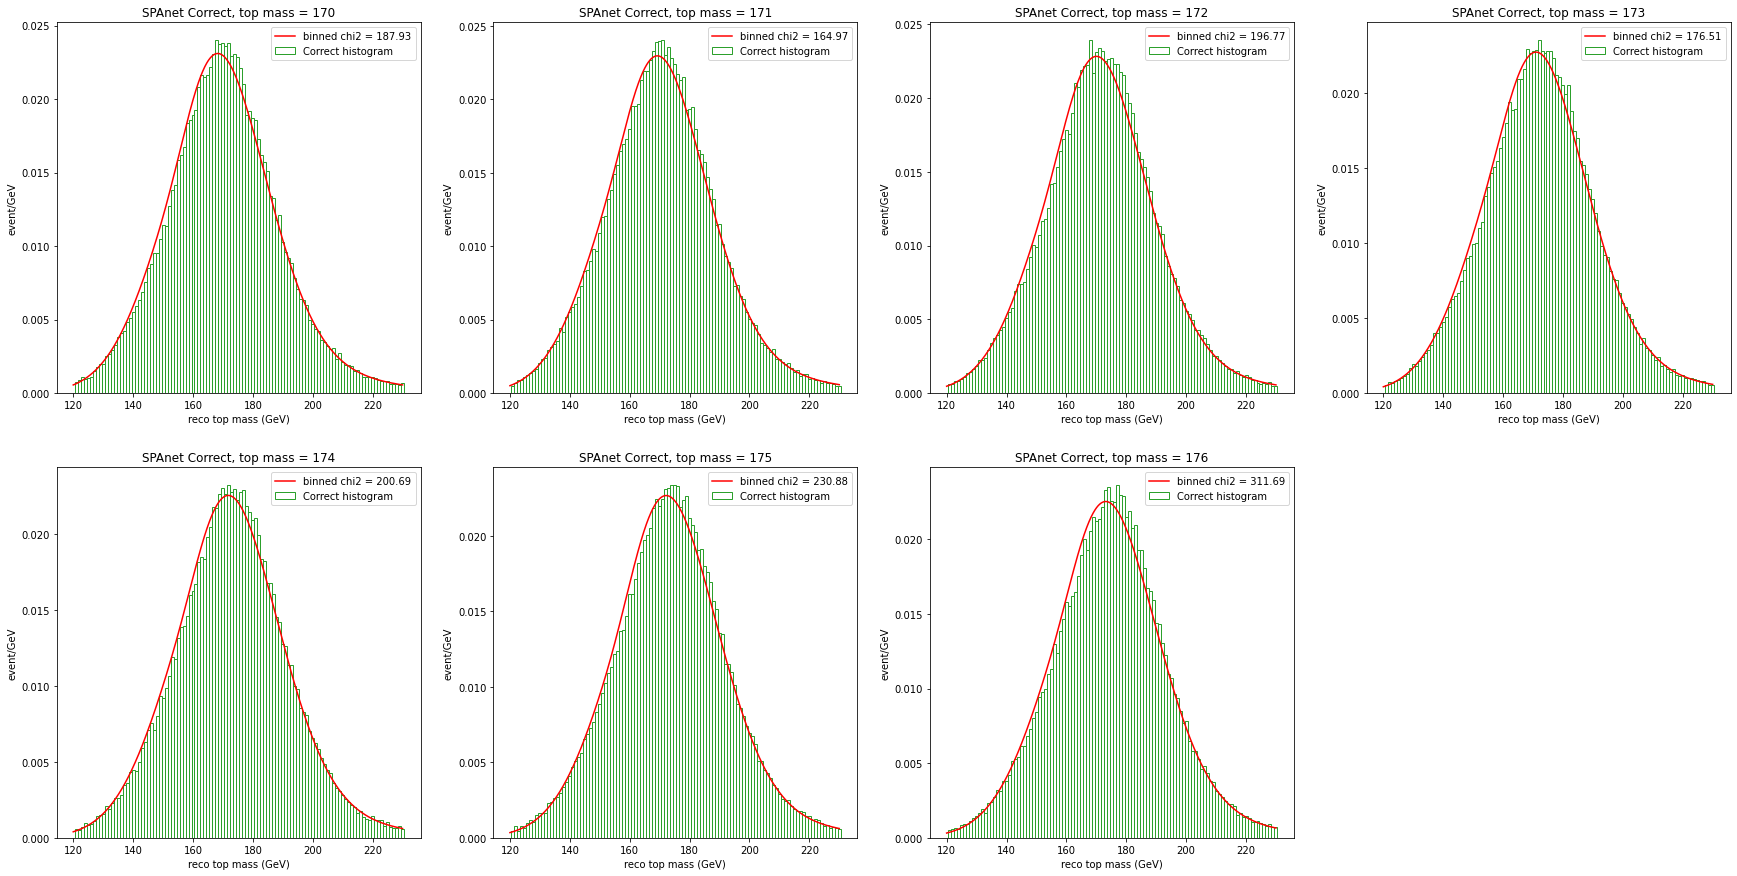

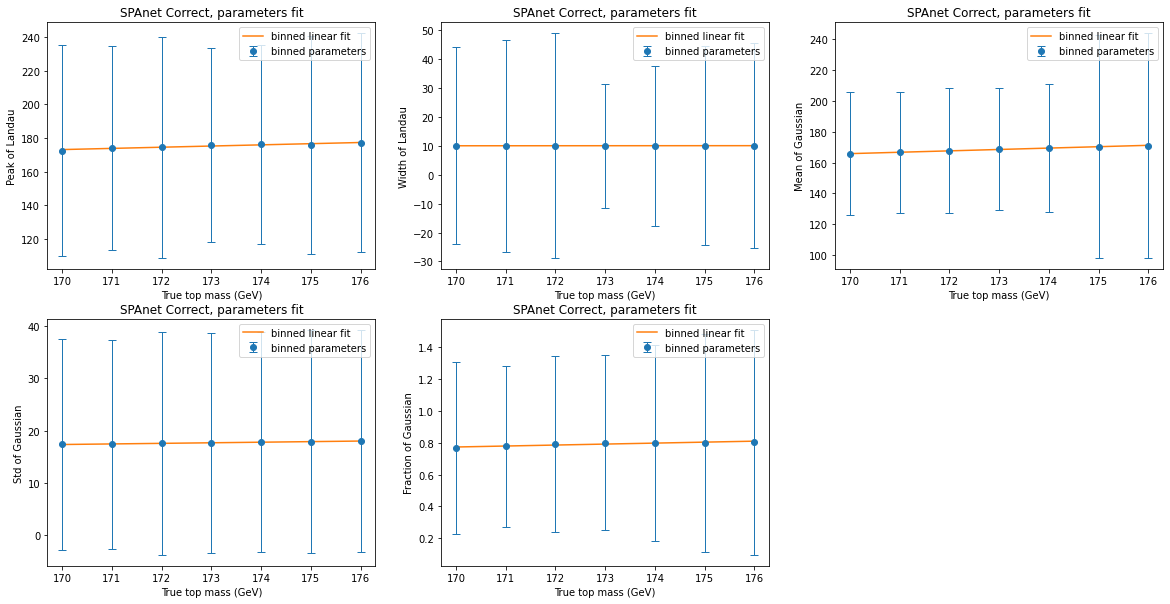

In [9]:
# Fit every class of spanet
fita_spanet_dic, fitb_spanet_dic = {}, {}
fit_popt_dic = {}
fit_perr_dic = {}

for state_i in [0, 1, 2]:
    popt_spanet_arr = []
    perr_spanet_arr = []
    
    plt.figure(figsize=(30, 15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        fit_target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m] == state_i))]
        hist, _ = np.histogram(fit_target, bins=bins, density=True)
        sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
        minuit = Minuit(fcn, 170, 30, 170, 30, 0.5)
        minuit.limits = [(120, 220), (10, 50), (120, 220), (10, 50), (0.01, 0.99)]
        minuit.migrad(iterate=1000)
        minuit.minos()
        popt = list(minuit.values)
        errors = list(minuit.errors)
        y_dense = langau_norm(bins_dense, *popt)
        chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))
        popt_spanet_arr.append(popt)
        perr_spanet_arr.append(errors)
        plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
        plt.title('SPAnet {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc = 'upper right')
    plt.show()

    popt_spanet_arr = np.transpose(np.array(popt_spanet_arr))
    fit_popt_dic[state_i] = popt_spanet_arr
    perr_spanet_arr = np.transpose(np.array(perr_spanet_arr))
    fita_spanet_arr, fitb_spanet_arr = [], []

    plt.figure(figsize=(20, 10))
    for i, arr in enumerate(popt_spanet_arr):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_spanet_arr[i], method="lm")
        perr = np.sqrt(np.diag(pcov))
        plt.errorbar(mass, arr, yerr = perr_spanet_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
        y = linear(top_mass_dense, popt[0], popt[1])
        plt.plot(top_mass_dense, y, label='binned linear fit')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
        plt.title('SPAnet {}, parameters fit'.format(state_labels[state_i]))
        fita_spanet_arr.append(popt[0])
        fitb_spanet_arr.append(popt[1])
        plt.legend(loc='upper right')
    plt.show()
    fita_spanet_dic[state_i] = fita_spanet_arr
    fitb_spanet_dic[state_i] = fitb_spanet_arr

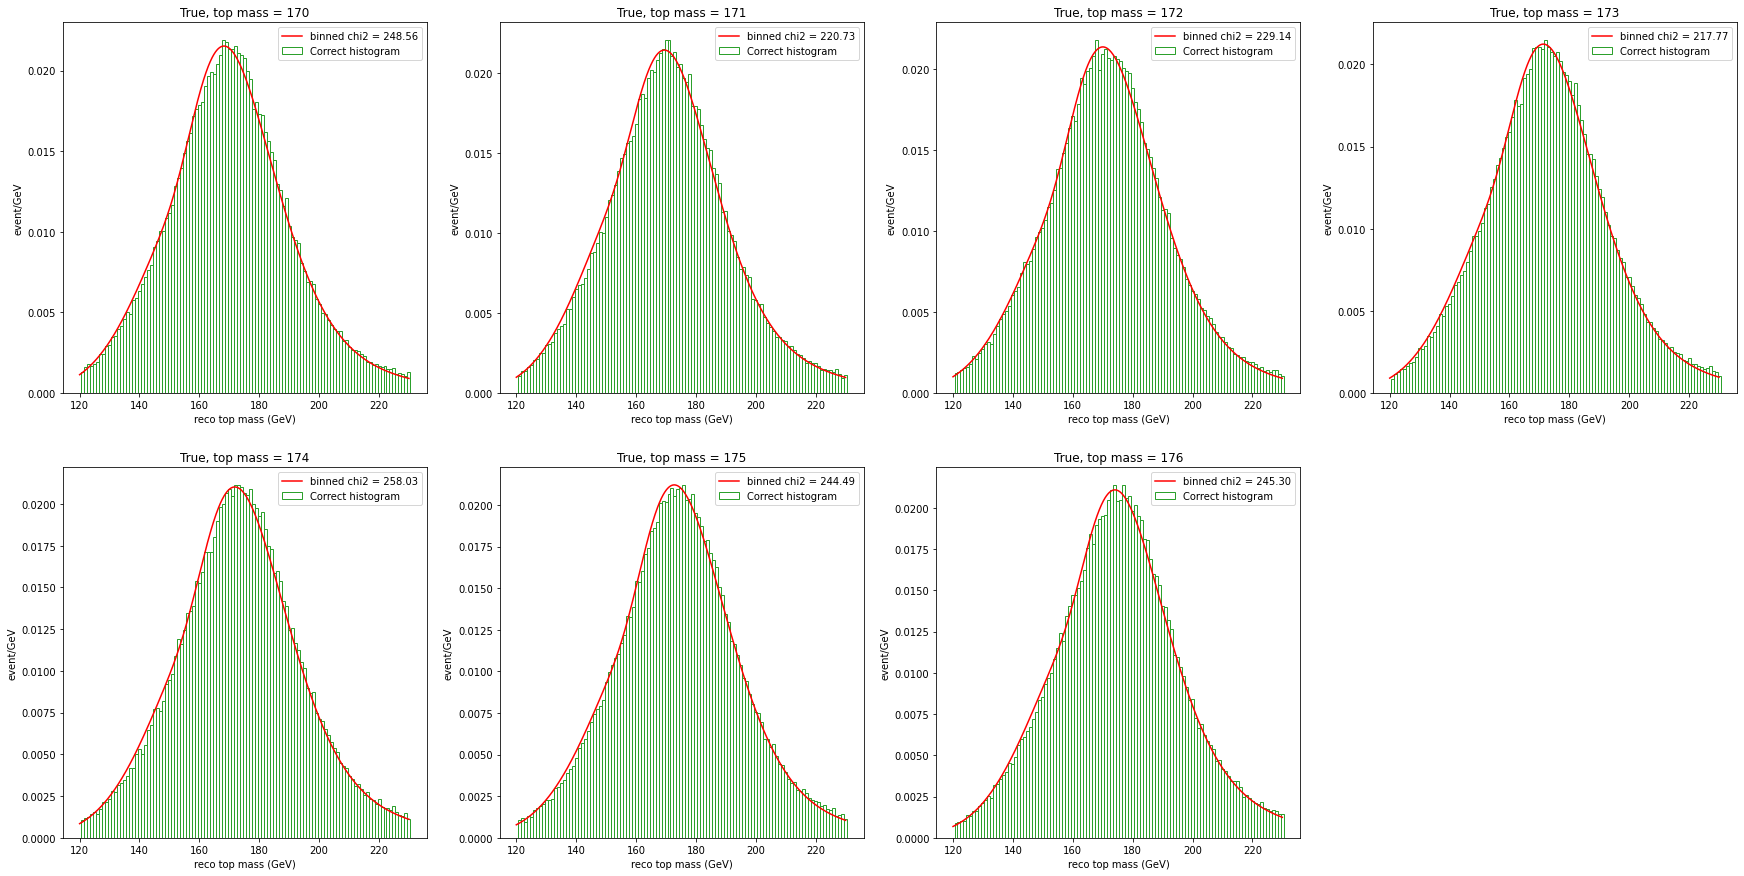

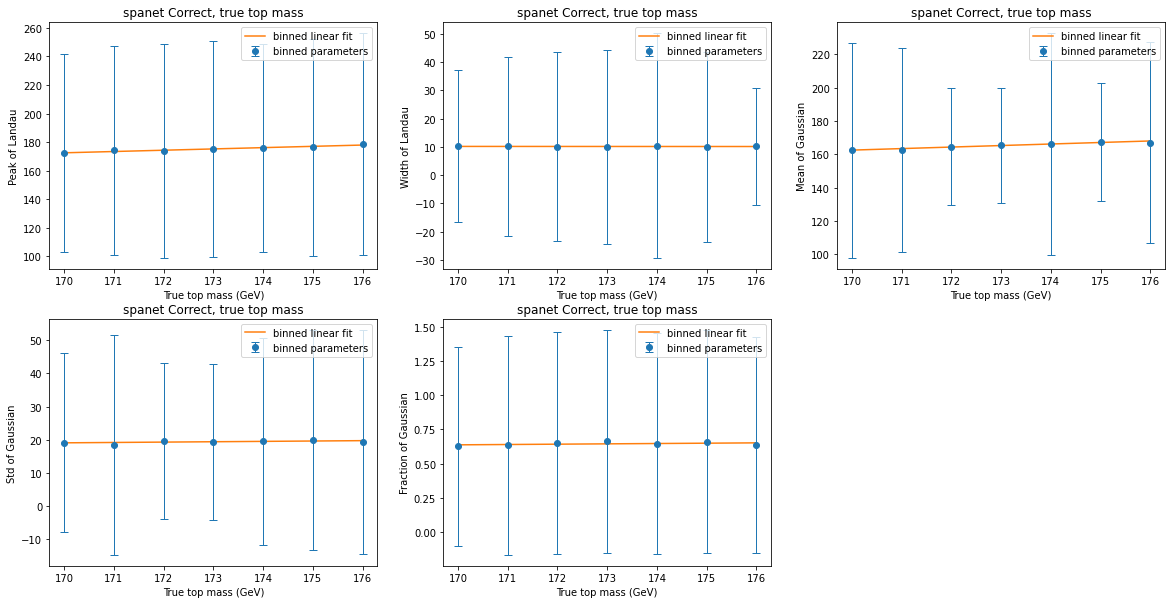

In [10]:
# Fit every class of true
fit_popt_dic = {}
fit_perr_dic = {}

popt_true_arr = []
perr_true_arr = []
    
plt.figure(figsize=(30, 15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    fit_target = reco_true_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_true_dic[m] == 2))]
    hist, _ = np.histogram(fit_target, bins=bins, density=True)
    sigma = np.sqrt(np.histogram(fit_target, bins=bins)[0])/len(fit_target)
    minuit = Minuit(fcn, 170, 30, 170, 30, 0.5)
    minuit.limits = [(120, 220), (10, 50), (120, 220), (10, 50), (0.01, 0.99)]
    minuit.migrad(iterate=1000)
    minuit.minos()
    popt = list(minuit.values)
    errors = list(minuit.errors)
    y_dense = langau_norm(bins_dense, *popt)
    chi2 = chi2_pdf(fit_target, langau_norm(bins_mid, *popt))
    popt_true_arr.append(popt)
    perr_true_arr.append(errors)
    plt.bar(bins[:-1]+1, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
    plt.plot(bins_dense, y_dense, c='r', label='binned chi2 = {:.2f}'.format(chi2))
    plt.title('True, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('event/GeV')
    plt.legend(loc = 'upper right')
plt.show()

popt_true_arr = np.transpose(np.array(popt_true_arr))
fit_popt_dic[state_i] = popt_spanet_arr
perr_true_arr = np.transpose(np.array(perr_true_arr))
fita_true_arr, fitb_true_arr = [], []

plt.figure(figsize=(20, 10))
for i, arr in enumerate(popt_true_arr):
    plt.subplot(2, 3, i+1)
    popt, pcov = optimize.curve_fit(linear, mass, arr, sigma=perr_true_arr[i], method="lm")
    perr = np.sqrt(np.diag(pcov))
    plt.errorbar(mass, arr, yerr = perr_true_arr[i], fmt='o', elinewidth=bins_w, capsize=4, label='binned parameters')
    y = linear(top_mass_dense, popt[0], popt[1])
    plt.plot(top_mass_dense, y, label='binned linear fit')
    plt.xlabel('True top mass (GeV)')
    plt.ylabel(langau_fit_labels[i])
    plt.title('spanet {}, true top mass'.format(state_labels[state_i], m))
    fita_true_arr.append(popt[0])
    fitb_true_arr.append(popt[1])
    plt.legend(loc='upper right')
plt.show()

array([176.7211402 ,   8.8787983 , 169.85634427,  18.11683383,
         0.7144712 ])

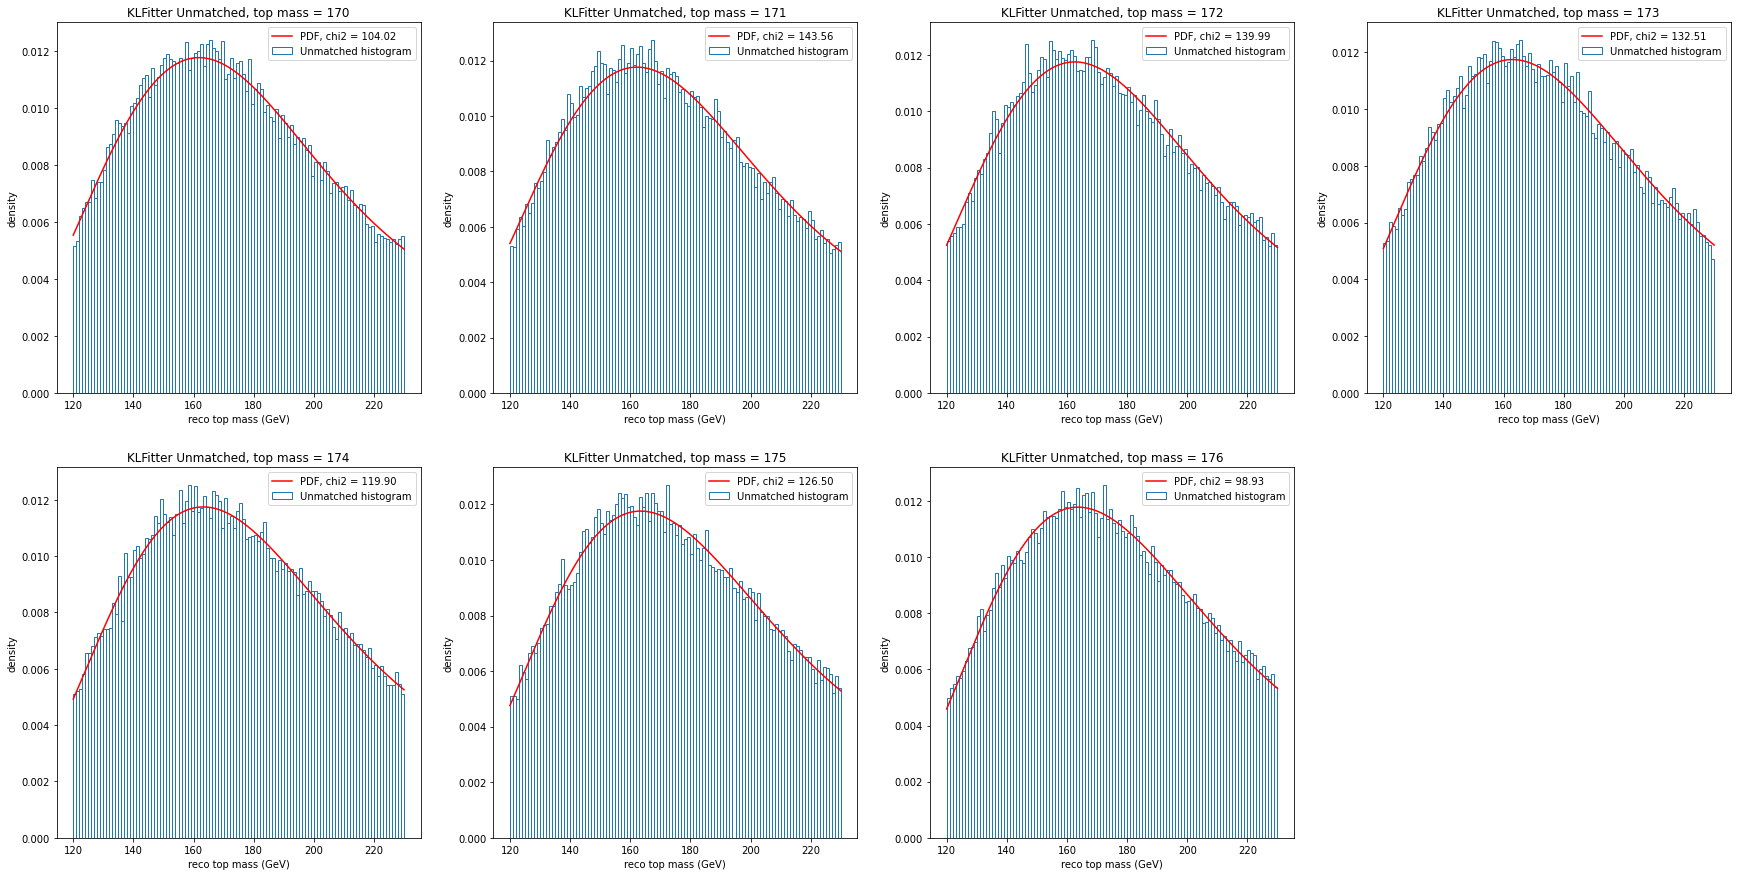

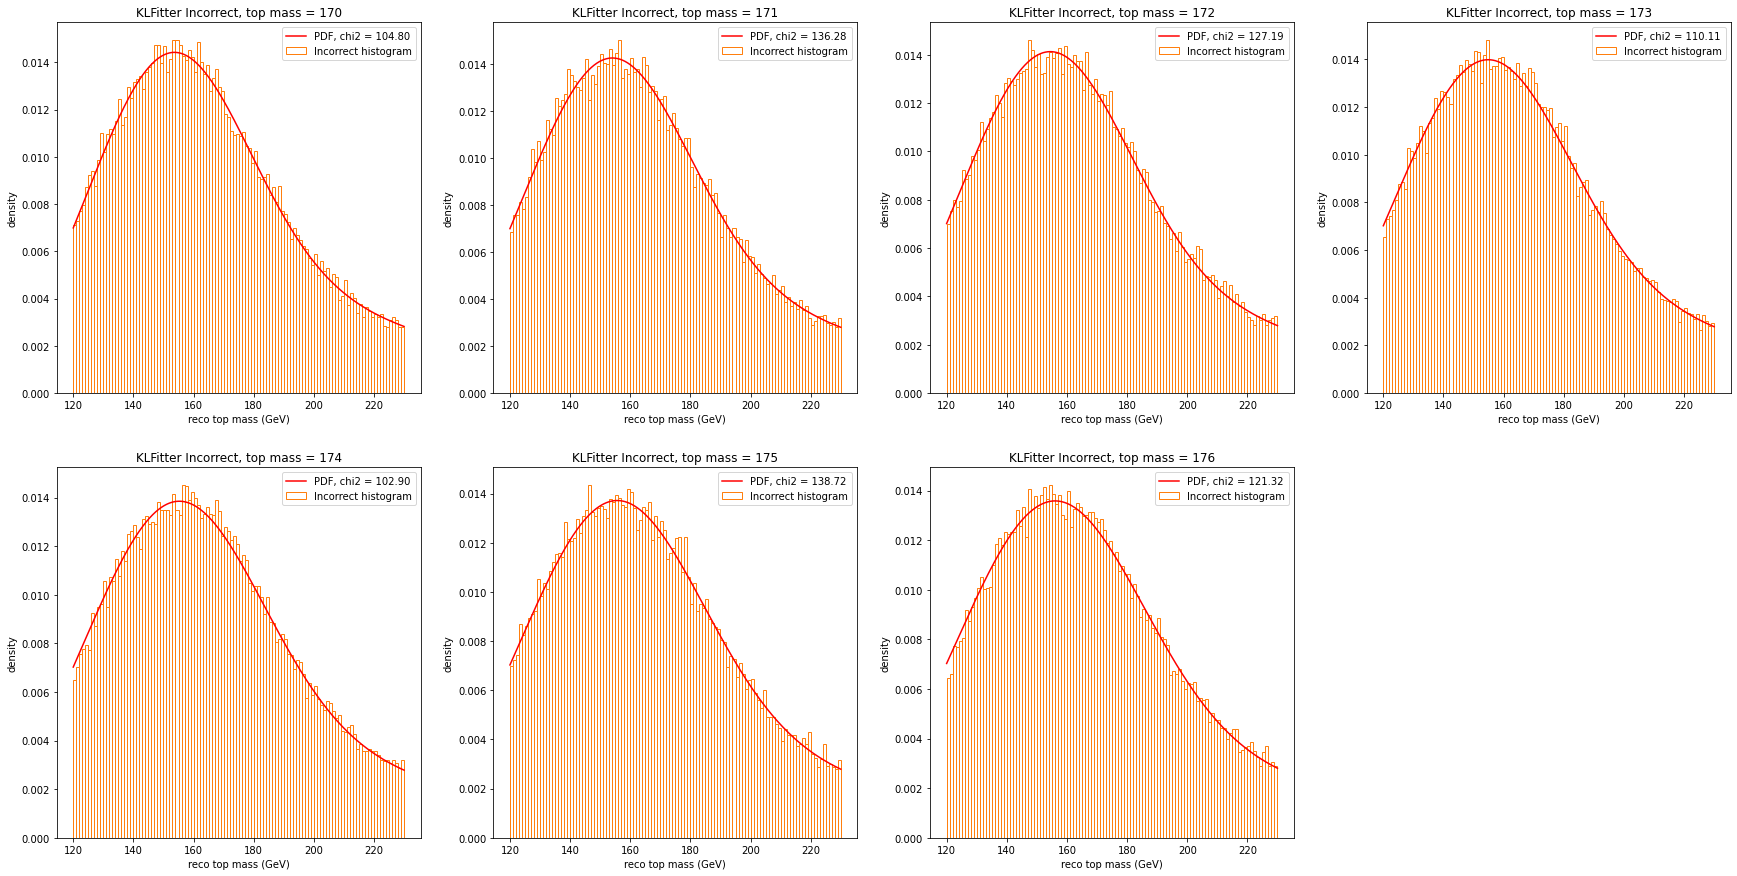

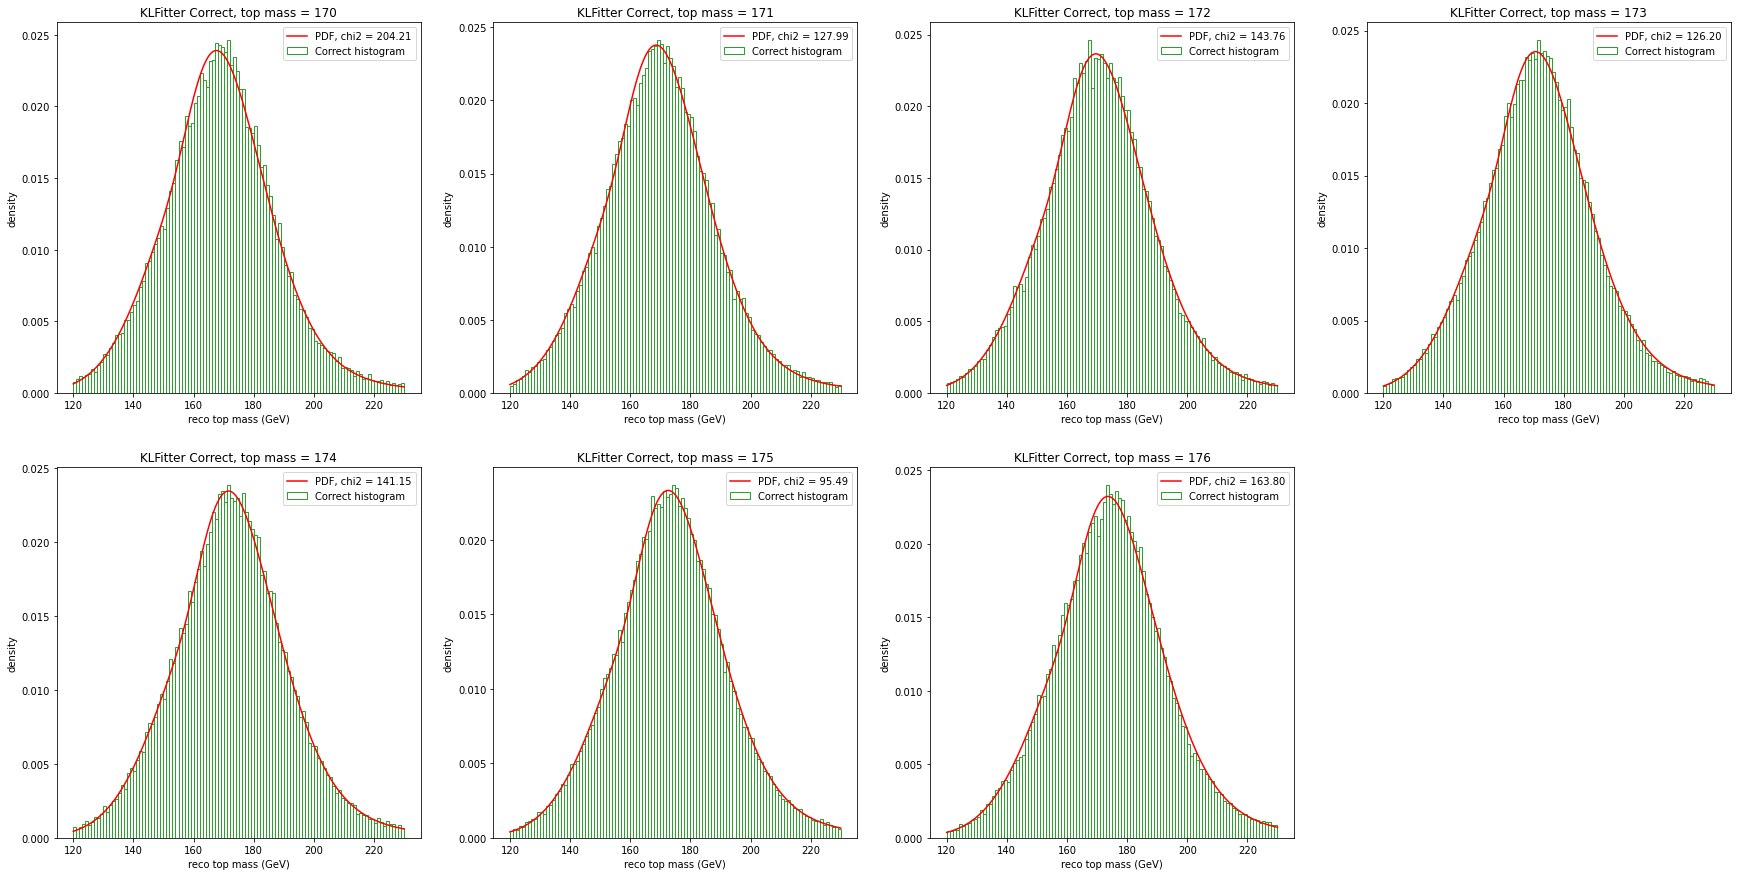

In [31]:
# Compare the klf template histogram and the pdf
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m], state_klf_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_klf_dic[state_i])*(m-173)+fitb_klf_dic[state_i]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('KLFitter {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

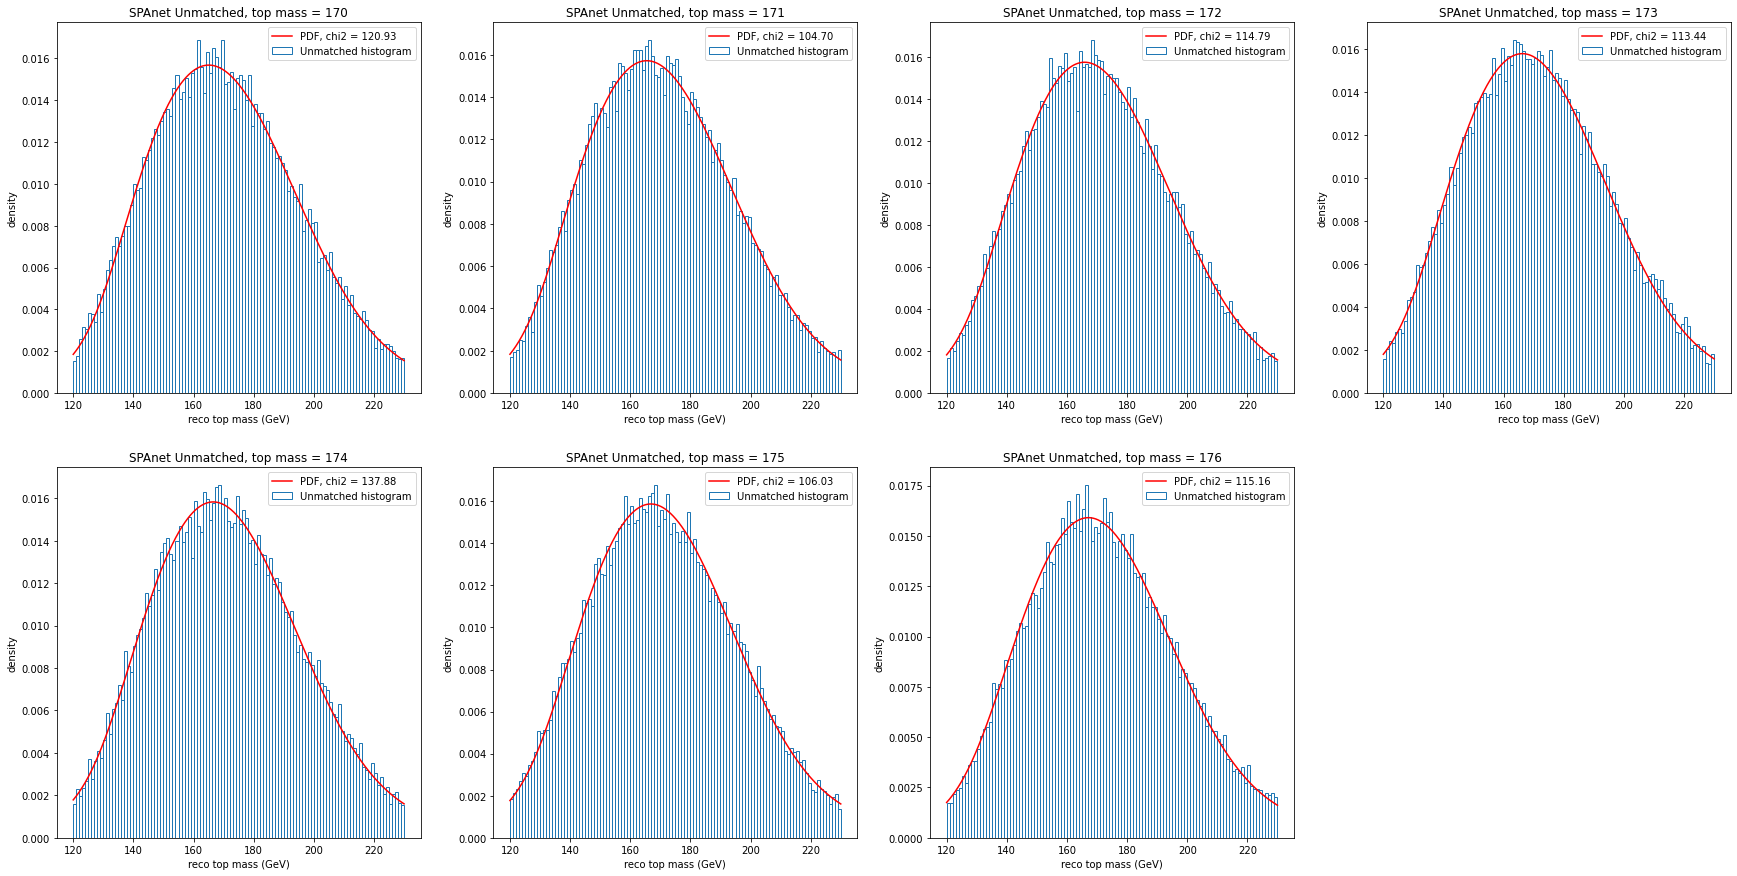

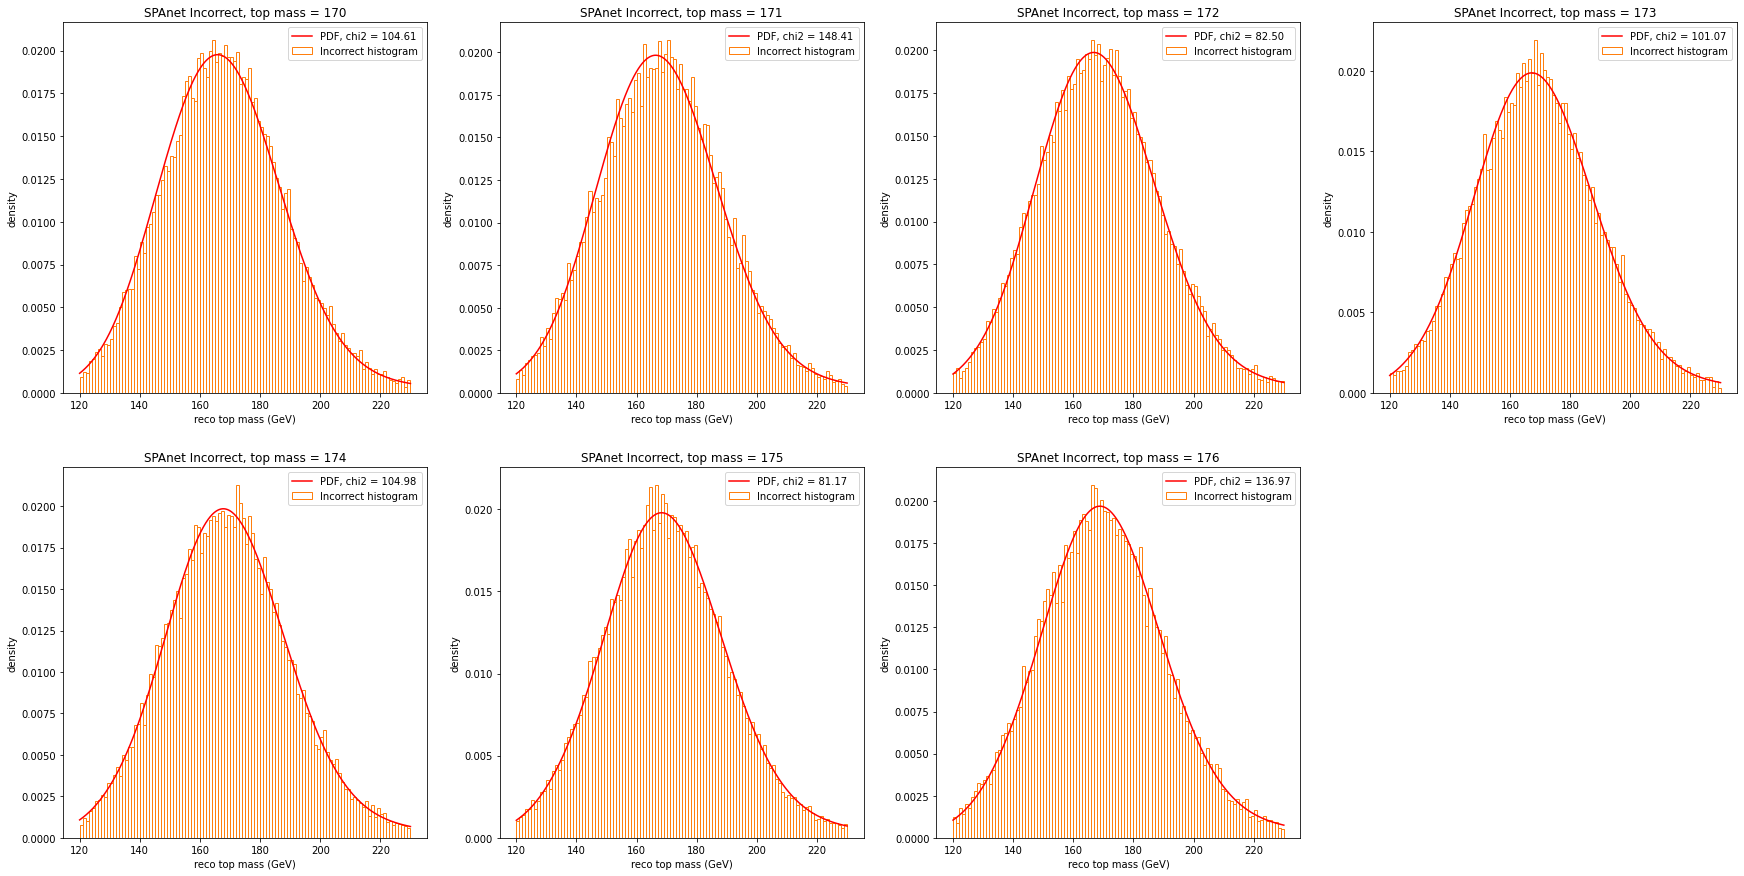

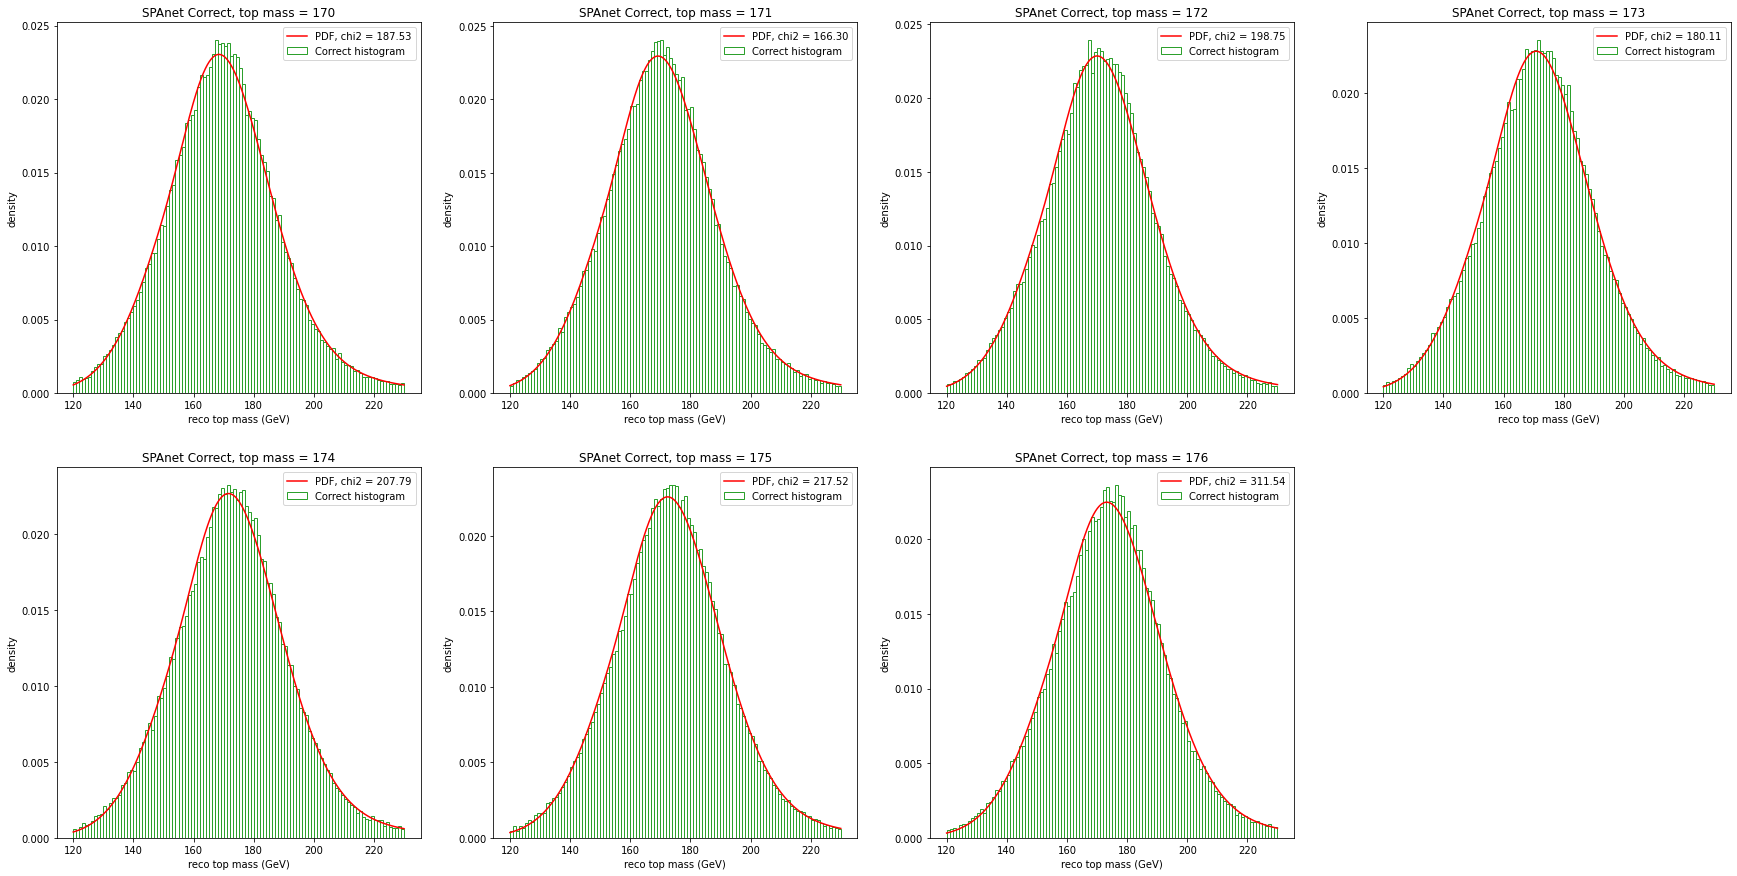

In [32]:
# Compare the spanet template histogram and the pdf
for state_i in [0, 1, 2]:
    plt.figure(figsize=(30,15))
    for i, m in enumerate(mass):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m], state_spanet_dic[m] == state_i))]
        hist, _ = np.histogram(target, bins=bins, density=True)
        popt = np.array(fita_spanet_dic[state_i])*(m-173)+fitb_spanet_dic[state_i]
        y_template_dense_norm = langau_norm(bins_dense, *popt)
        chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
        plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
        plt.title('SPAnet {}, top mass = {}'.format(state_labels[state_i], m))
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('density')
        plt.legend(loc='upper right')
    plt.show()

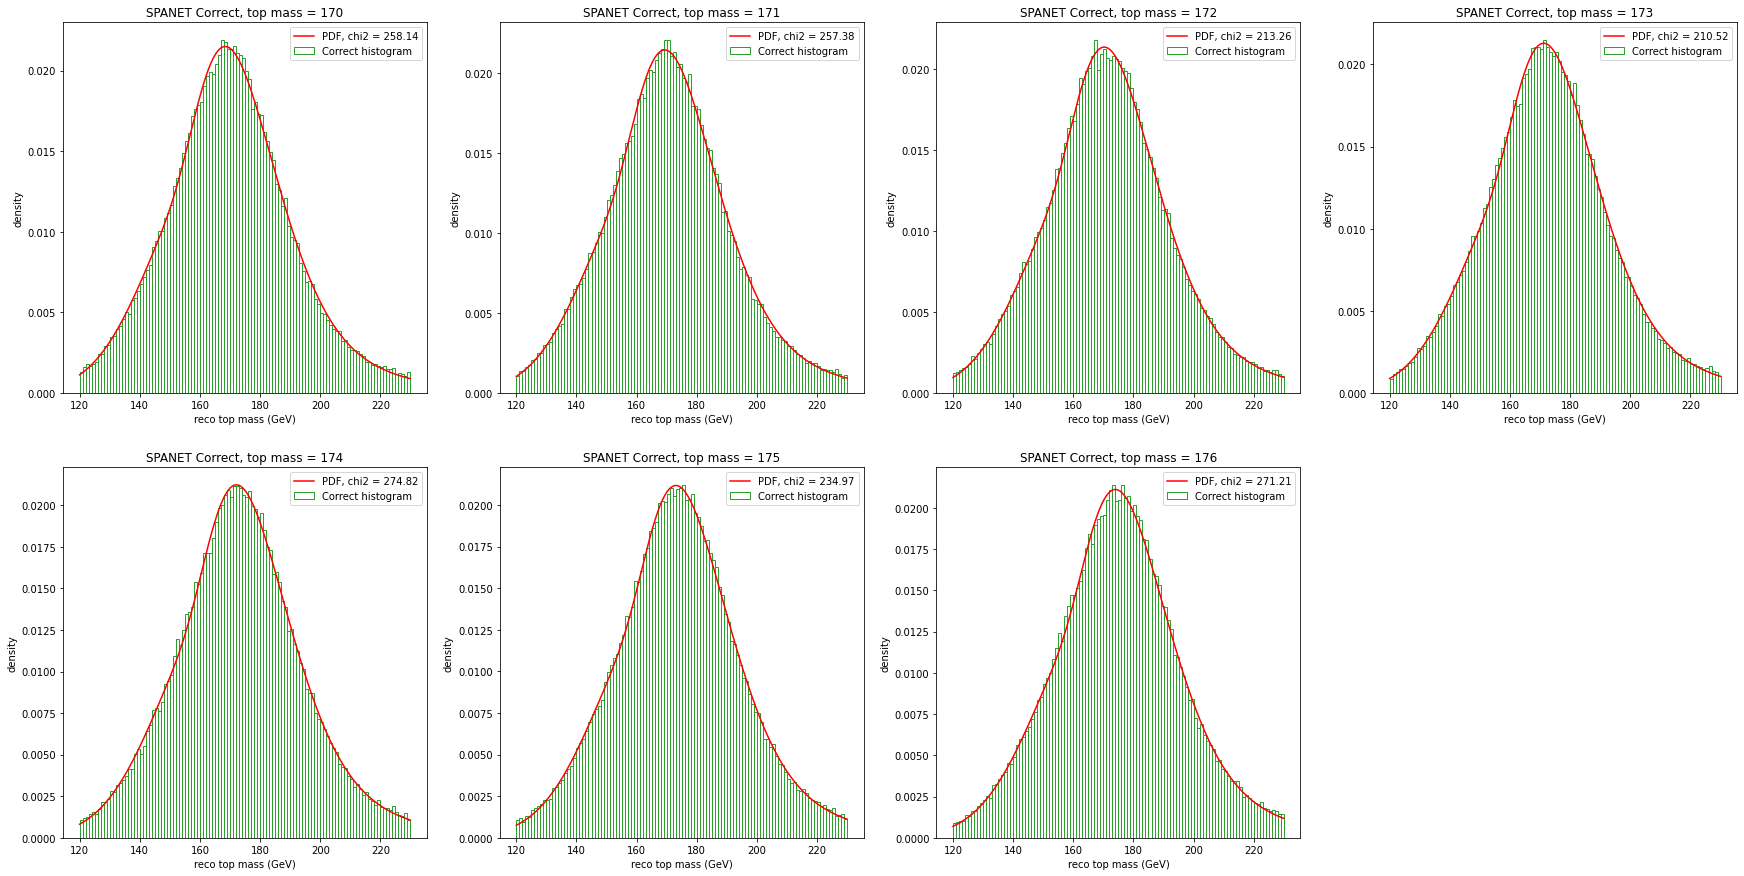

In [33]:
# Compare the true template histogram and the pdf
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_true_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_true_dic[m] == 2))]
    hist, _ = np.histogram(target, bins=bins, density=True)
    popt = np.array(fita_true_arr)*(m-173)+fitb_true_arr
    y_template_dense_norm = langau_norm(bins_dense, *popt)
    chi2_pdf_value = chi2_pdf(target, langau_norm(bins_mid, *popt))
    plt.bar(bins_mid, hist, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
    plt.plot(bins_dense, y_template_dense_norm, c='r', label='PDF, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPANET {}, top mass = {}'.format(state_labels[state_i], m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [34]:
def combine_klf_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_klf_dic[state_i])*(m-173) + fitb_klf_dic[state_i]
        hist += langau_norm(x, *popt)*ratio_klf[state_i]
    return hist

def combine_spanet_pdf_func(x, m):
    hist = [0]*len(x)
    for state_i in [0, 1, 2]:
        popt = np.array(fita_spanet_dic[state_i])*(m-173) + fitb_spanet_dic[state_i]
        hist += langau_norm(x, *popt)*ratio_spanet[state_i]
    return hist

def combine_true_pdf_func(x, m):
    popt = np.array(fita_true_arr)*(m-173) + fitb_true_arr
    return langau_norm(x, *popt)*ratio_spanet[state_i]

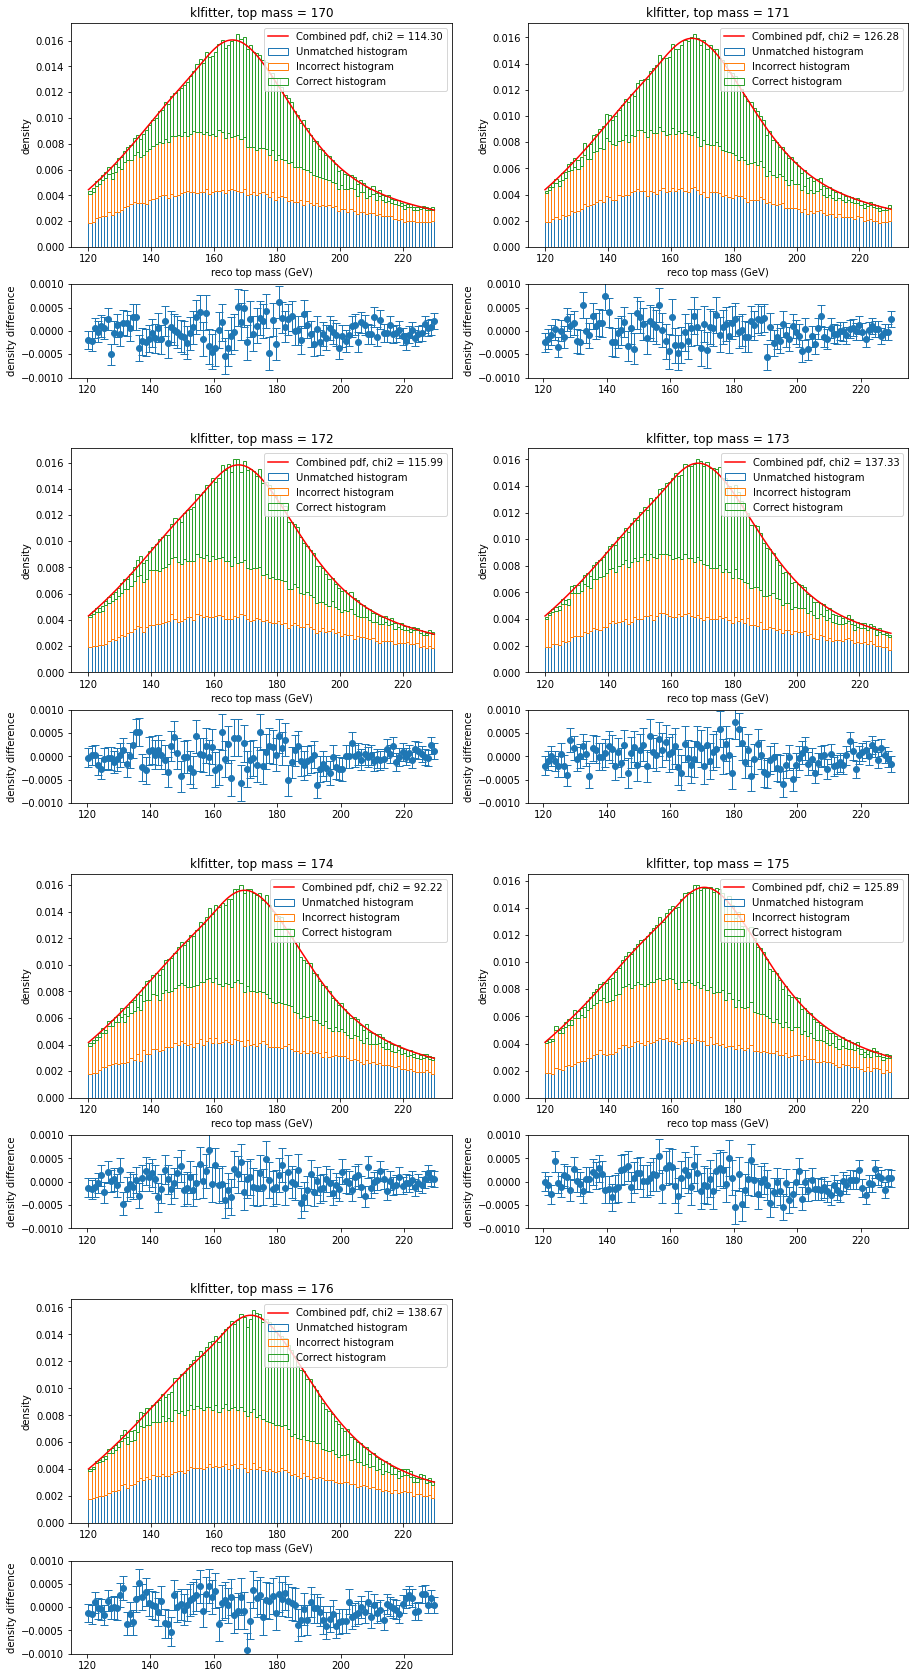

In [35]:
fig = plt.figure(figsize=(15,30))
outer = gridspec.GridSpec(4, 2, wspace=0.2, hspace=0.2)
for i, m in enumerate(mass):
    inner = gridspec.GridSpecFromSubplotSpec(3, 1,
                subplot_spec=outer[i], wspace=0.2, hspace=0.4)
    ax = plt.Subplot(fig, inner[:2])
    target = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins)
        ax.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    ax.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    ax.set_title('klfitter, top mass = {}'.format(m))
    ax.set_xlabel('reco top mass (GeV)')
    ax.set_ylabel('density')
    ax.legend(loc='upper right')
    fig.add_subplot(ax)
    
    ax = plt.Subplot(fig, inner[2])
    hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins, density=True)
    sigma = np.sqrt(np.histogram(target, bins=bins)[0])/len(fit_target)
    ax.errorbar(bins_mid, hist-combine_klf_pdf_func(bins_mid, m), yerr=sigma, fmt='o', elinewidth=bins_w, capsize=4)
    ax.set_ylabel('density difference')
    ax.set_ylim(-0.001, 0.001)
    fig.add_subplot(ax)
plt.show()

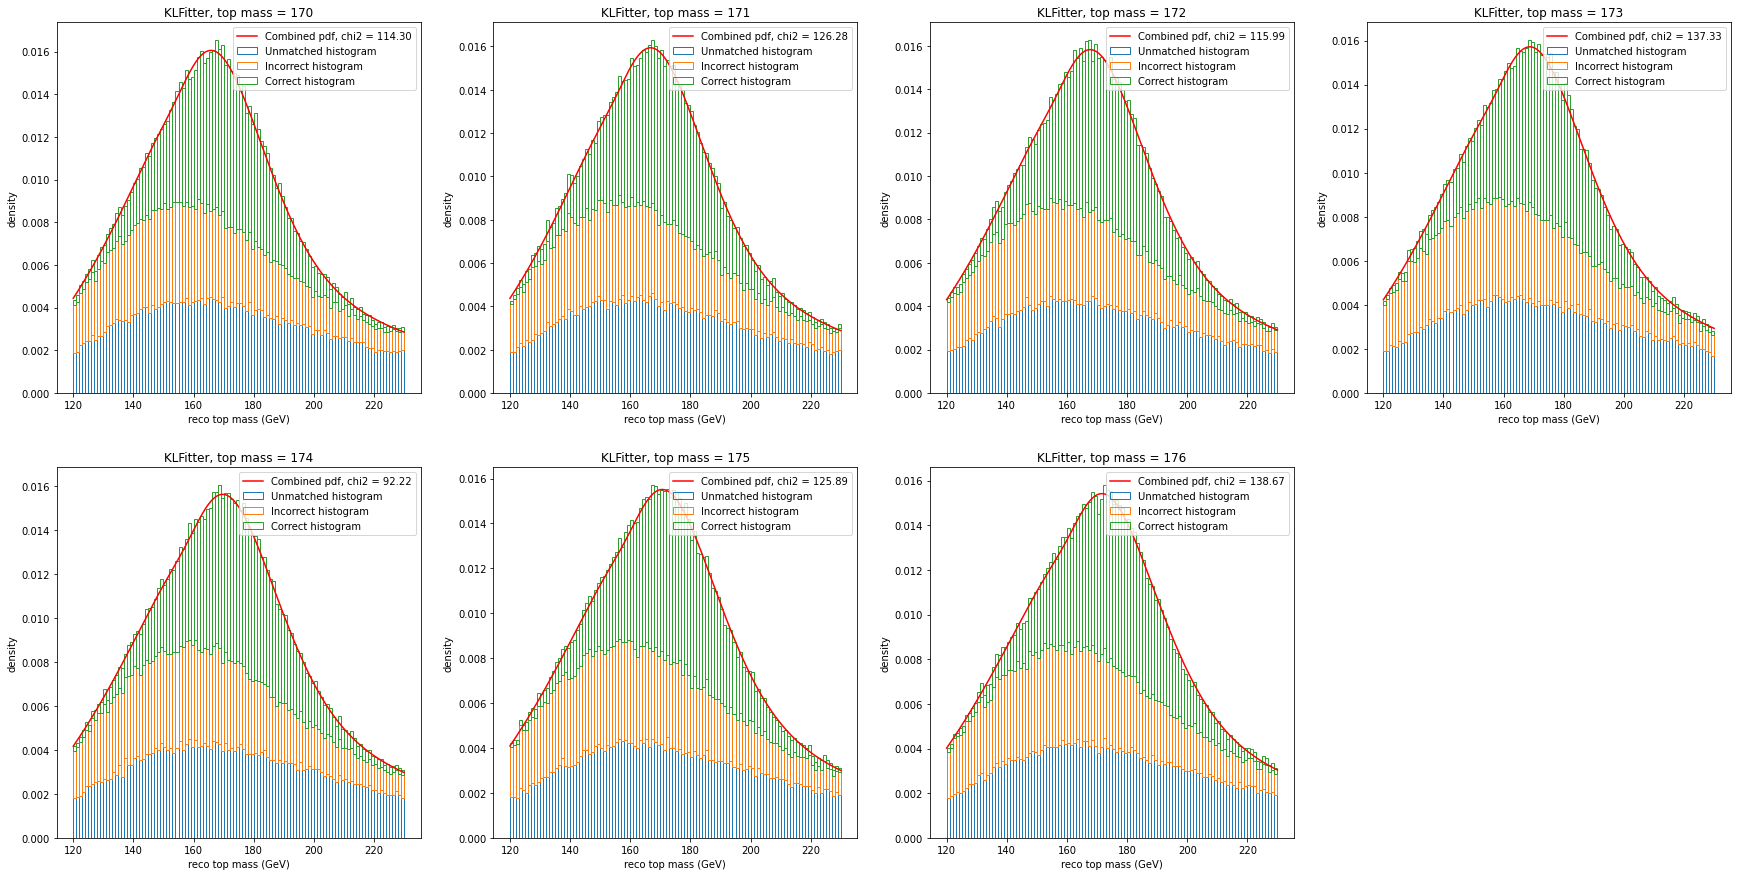

In [36]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
    klf_pdf = combine_klf_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_klf_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_klf_dic[m][np.logical_and.reduce((state_klf_dic[m] == state_i, likeli_klf_dic[m], cut_klf_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, klf_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('KLFitter, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

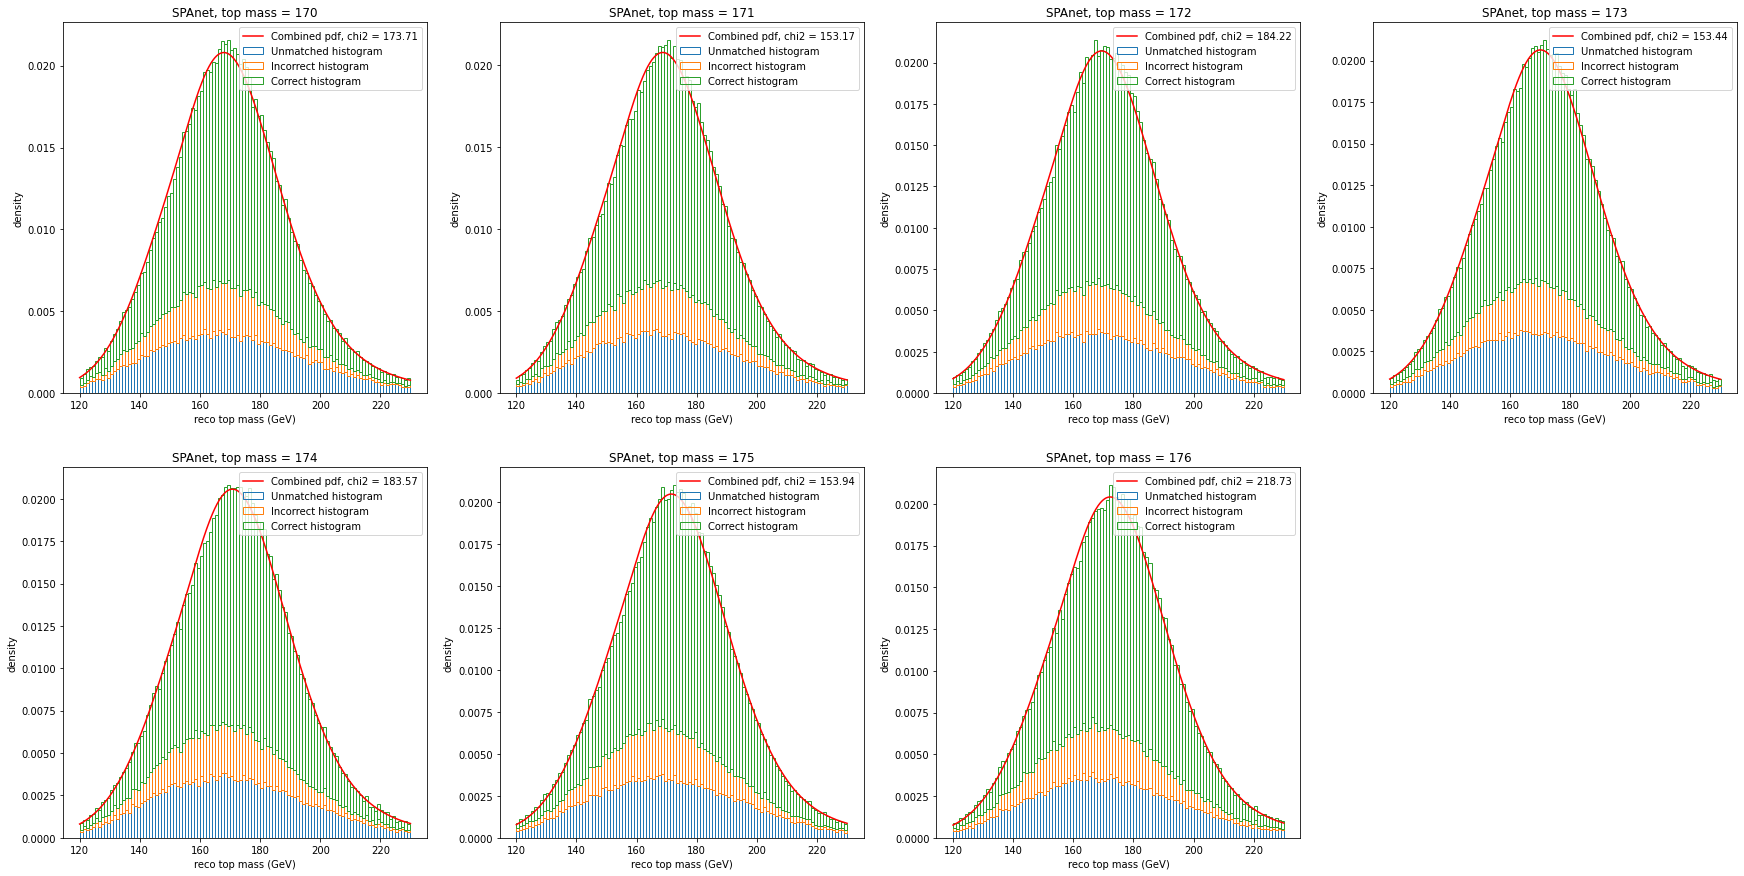

In [37]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    target = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
    spanet_pdf = combine_spanet_pdf_func(bins_dense, m)
    chi2_pdf_value = chi2_pdf(target, combine_spanet_pdf_func(bins_mid, m))

    h, tot = [0]*(len(bins)-1), len(target)
    for state_i in [0, 1, 2]:
        hist, _ = np.histogram(reco_spanet_dic[m][np.logical_and.reduce((state_spanet_dic[m] == state_i, likeli_spanet_dic[m], cut_spanet_dic[m]))], bins=bins)
        plt.bar(bins_mid, hist/tot/bins_w, bottom=h, edgecolor=colors[state_i], width=bins_w, color='None', label = state_labels[state_i] + ' histogram')
        h += hist/tot/bins_w

    plt.plot(bins_dense, spanet_pdf, c='r', label='Combined pdf, chi2 = {:.2f}'.format(chi2_pdf_value))
    plt.title('SPAnet, top mass = {}'.format(m))
    plt.xlabel('reco top mass (GeV)')
    plt.ylabel('density')
    plt.legend(loc='upper right')
plt.show()

In [38]:
def chi2_klf_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_klf_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_spanet_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_spanet_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

def chi2_true_arr_func(m):
    return -2*np.sum(n1*(np.log(combine_true_pdf_func(bins_mid, m)*len(n1)*bins_w))) + 2*len(n1)

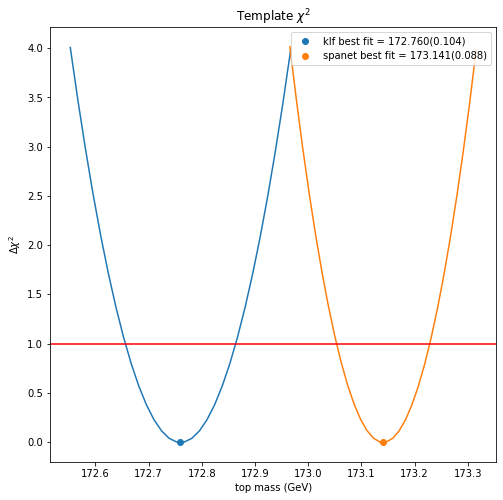

In [39]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

sudo_spanet = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
# n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='spanet best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_spanet_mtop, template_spanet_std = minuit.values['m'], minuit.errors['m']

# sudo_true = reco_true_dic[m][np.logical_and.reduce((cut_spanet_dic[m], state_true_dic[m] == 2))]
# n1 = np.histogram(sudo_true, bins=bins)[0]
# # n1 = combine_true_pdf_func(bins_mid, m)*tot_event*bins_w
# # n1 = np.random.poisson(n1)
# minuit = Minuit(chi2_true_arr_func, m=m)
# minuit.migrad()
# minuit.hesse()
# minuit.minos()
# a, fa, ok = minuit.mnprofile("m")
# plt.plot(a, fa-min(fa))
# plt.scatter(minuit.values['m'], 0, label='true best fit = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
# template_true_mtop, template_true_std = minuit.values['m'], minuit.errors['m']

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

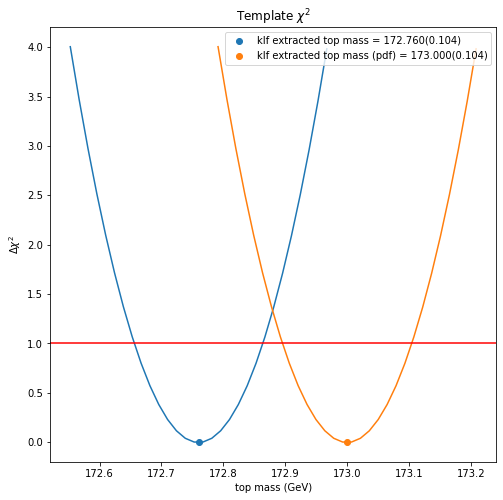

In [42]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf extracted top mass = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
# n1 = np.histogram(sudo_klf, bins=bins)[0]
n1 = combine_klf_pdf_func(bins_mid, m)*len(sudo_klf)*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
plt.plot(a, fa-min(fa))
plt.scatter(minuit.values['m'], 0, label='klf extracted top mass (pdf) = {:.3f}({:.3f})'.format(minuit.values['m'], minuit.errors['m']))
template_klf_mtop, template_klf_std = minuit.values['m'], minuit.errors['m']

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [20]:
#Sudo experiment for KLFitter top mass
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}

for m in mass:
    sudo_klf = reco_klf_dic[m][np.logical_and.reduce((cut_klf_dic[m], likeli_klf_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_klf, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in tqdm(range(sudo_event)):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_klf_arr_func, m=m)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_klf_top_mean_dic[m] = mean
    sudo_klf_top_std_dic[m] = std

 22%|████████████████████████████████                                                                                                                 | 2210/10000 [01:45<06:13, 20.87it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.8, m+0.5, 0.02)
    plt.hist(sudo_klf_top_mean_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('KLFitter true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(0.1, 0.11, 0.0001)
    plt.hist(sudo_klf_top_std_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('KLFitter true top mass = {}'.format(m))
    plt.xlabel('best fit std')
    plt.ylabel('density/0.0001 best fit std')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter true and prediction comparison for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

klf_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_klf_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_klf_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_klf_top_func(extracted_top): return (np.array(extracted_top) - klf_popt[1])/klf_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(predicted_klf_top_func(sudo_klf_top_mean_dic[m]), bins=bins_top, density=True, histtype='step')
    plt.title('KLFitter biased fixed, true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_klf_top_func(sudo_klf_top_mean_dic[m])-m) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[m]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))
klf_top_pull = [(predicted_klf_top_func(sudo_klf_top_mean_dic[m])-m)/sudo_klf_top_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
klf_pull_mean, klf_pull_mean_std, klf_pull_sigma, klf_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('KLFitter top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#Sudo experiment for KLFitter top mass
sudo_spanet_top_mean_dic = {}
sudo_spanet_top_std_dic = {}

for m in mass:
    sudo_spanet = reco_spanet_dic[m][np.logical_and.reduce((cut_spanet_dic[m], likeli_spanet_dic[m]))]
    n1_arr = np.random.poisson(np.histogram(sudo_spanet, bins=bins)[0], size=(sudo_event, (bins_max-bins_min)//bins_w))
    mean, std = [], []
    for i in tqdm(range(sudo_event)):
        n1 = n1_arr[i]
        minuit = Minuit(chi2_spanet_arr_func, m=m)
        minuit.limits = [(166, 180)]
        minuit.migrad()
        minuit.minos()
        mean.append(minuit.values['m'])
        std.append(minuit.errors['m'])
    sudo_spanet_top_mean_dic[m] = mean
    sudo_spanet_top_std_dic[m] = std

In [ ]:
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.8, m+0.5, 0.02)
    plt.hist(sudo_spanet_top_mean_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('SPAnet true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(0.085, 0.09, 0.0001)
    plt.hist(sudo_spanet_top_std_dic[m], bins=bins_top, density=True, histtype='step')
    plt.title('SPAnet true top mass = {}'.format(m))
    plt.xlabel('best fit std')
    plt.ylabel('density/0.0001 best fit std')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet true and prediction comparison for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[m])-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

spanet_top_popt, _ = optimize.curve_fit(linear, mass, [np.mean(sudo_spanet_top_mean_dic[m]) for m in mass], sigma=[np.std(sudo_spanet_top_mean_dic[m])/np.sqrt(sudo_event) for m in mass], method="lm")
def predicted_spanet_top_func(extracted_top): return (np.array(extracted_top) - spanet_top_popt[1])/spanet_top_popt[0] + 173

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]), bins=np.arange(m-0.5, m+0.5, 0.02), density=True, histtype='step')
    plt.title('SPAnet biased fixed, true top mass = {}'.format(m))
    plt.xlabel('best fit top mass')
    plt.ylabel('density/0.2 best fit top mass')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m])) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('true top mass (GeV)')
plt.ylabel('mean of calibrated top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m]))-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[m]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('top mass (GeV)')
plt.ylabel('bias (GeV)')
plt.show()

plt.figure(figsize = (6, 6))
spanet_top_pull = [(predicted_spanet_top_func(sudo_spanet_top_mean_dic[m])-m)/sudo_spanet_top_std_dic[m] for m in mass]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau_norm, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = 'Mean = {:.4f} ({:.4f}), std = {:.4f} ({:.4f})'.format(popt[0], perr[0], popt[1], perr[1]))
spanet_pull_mean, spanet_pull_mean_std, spanet_pull_sigma, spanet_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('SPAnet top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('top mass pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.show()

In [ ]:
m = 173
plt.figure(figsize=(8, 8))
sudo_klf = reco_klf_dic[m][np.logical_and(cut_klf_dic[m], likeli_klf_dic[m])]
n1 = np.histogram(sudo_klf, bins=bins)[0]
# n1 = combine_klf_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_klf_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
template_klf_mtop, template_klf_std = predicted_klf_top_func(minuit.values['m']), minuit.errors['m']
plt.plot(predicted_klf_top_func(a), fa-min(fa))
plt.scatter(template_klf_mtop, 0, label='klf best fit = {:.3f}({:.3f})'.format(template_klf_mtop, template_klf_std))

sudo_spanet = reco_spanet_dic[m][np.logical_and(cut_spanet_dic[m], likeli_spanet_dic[m])]
n1 = np.histogram(sudo_spanet, bins=bins)[0]
# n1 = combine_spanet_pdf_func(bins_mid, m)*tot_event*bins_w
# n1 = np.random.poisson(n1)
minuit = Minuit(chi2_spanet_arr_func, m=m)
minuit.migrad()
minuit.hesse()
minuit.minos()
a, fa, ok = minuit.mnprofile("m")
template_spanet_mtop, template_spanet_std = predicted_spanet_top_func(minuit.values['m']), minuit.errors['m']
plt.plot(predicted_spanet_top_func(a), fa-min(fa))
plt.scatter(template_spanet_mtop, 0, label='spanet best fit = {:.3f}({:.3f})'.format(template_spanet_mtop, template_spanet_std))

plt.axhline(1, c='r')
plt.title(r'Template $\chi^2$')
plt.xlabel('top mass (GeV)')
plt.ylabel(r'$\Delta \chi^2$')
plt.legend(loc='upper right')
plt.show()

In [ ]:
print('{:.2f}({:.2f})'.format((template_klf_mtop-klf_popt[1])/klf_popt[0], template_klf_std))
print('{:.3f}({:.3f})'.format(klf_pull_mean, klf_pull_mean_std))
print('{:.4f}({:.4f})'.format(klf_pull_sigma, klf_pull_sigma_std))
print('{:.3f}({:.3f})'.format((template_spanet_mtop-spanet_popt[1])/spanet_popt[0], template_spanet_std))
print('{:.4f}({:.4f})'.format(spanet_pull_mean, spanet_pull_mean_std))
print('{:.4f}({:.4f})'.format(spanet_pull_sigma, spanet_pull_sigma_std))